In [1]:
import numpy as np
import json
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
import collections
import torch
from toytask_utils import make_tasks, all_divisions
from divergence_utils import SymmetricDefiniteMatrix
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

csv_id = None

# Generate Initial Data

In [2]:
n_samples = 100 # number of times to resample each class
x_values = [-1,1] # valid causal x values
y_values = [i for i in range(5)] # valid causal y values
std = 0.1 # standard deviation of noise along causal dims
cov = 0.2 # covariance between causal dims

varbs = []
for x in x_values:
    for y in y_values:
        varbs.append([x,y])
varbs = np.asarray(varbs)

samples = []
og_varbs = []
xmean = 0
ymean = 0
for _ in range(n_samples):
    samp = varbs.copy().astype(float)
    og_varbs.append(varbs.copy())
    samp[:,0] += cov*samp[:,1]
    noise = std*np.random.randn(*samp.shape)
    samp = samp + noise
    samples.append(samp)
samples = np.vstack(samples)
samples = samples - samples.mean(0)
og_varbs = np.vstack(og_varbs)
print(samples.shape)

(1000, 2)


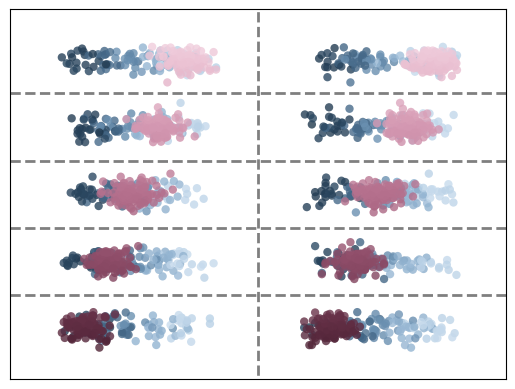

In [3]:
df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])


fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
thickness = 2
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
ax.plot([0,0],[-3,3], "k--", alpha=0.5, linewidth=thickness)
# x dividers
for i in y_values[:-1]:
    y = i+0.5-2
    ax.plot([-2,2],[y,y], "k--", alpha=0.5, linewidth=thickness)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
#native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
#intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

#ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
plt.legend().set_visible(False)
#plt.savefig("figs/example_divergence.png", dpi=600, bbox_inches="tight")

plt.show()

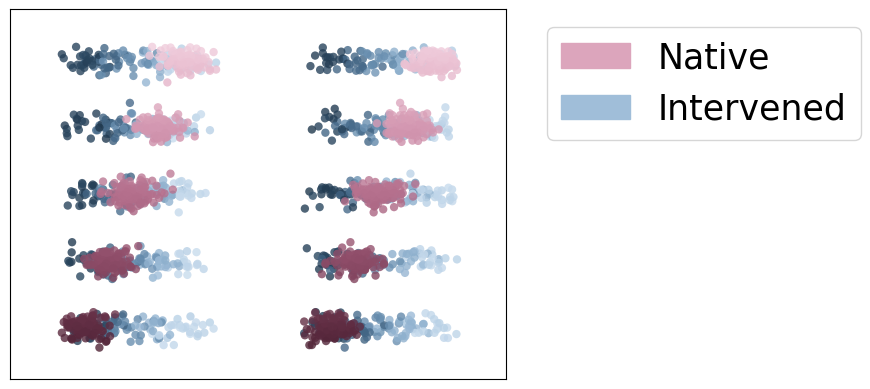

In [4]:
import matplotlib.patches as mpatches
import matplotlib as mpl

df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])



fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
#ax.plot([0,0],[-1,5], "k--", alpha=0.5)
## x dividers
#for i in y_values[:-1]:
#    y = i+0.5
#    ax.plot([-2,2],[y,y], "k--", alpha=0.5)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
#plt.savefig("figs/legend.png", dpi=600, bbox_inches="tight")

plt.show()

In [5]:
from geomloss import SamplesLoss
kwargs = {
    "loss": "sinkhorn",
    "p": 2,
    "blur": 0.05,
}
loss_fn = SamplesLoss(**kwargs)

def compute_emd(X,Y):
    return loss_fn(X.float(),Y.float())


# CL Loss

In [6]:
print(og_varbs.shape)
print(samples.shape)

(1000, 2)
(1000, 2)


In [7]:
def quick_plot(
    natty,
    intrv,
    natty_classes=None,
    intrv_classes=None,
    save_name=None,
    incl_legend=False,
    incl_dividers=True,
    xlim=[-2,2],
    ylim=[-2.75,2.75],
    incl_ticks=False,
    labels=["Native", "Intervened"],
    intrv_cmap=None,
    native_cmap=None,
    intrv_color=None,
    native_color=None,
    intrv_alpha = 0.95,
    native_alpha = 0.6,
    thickness=2,
    dash_alpha=0.5,
    legendsize = 25,
    dark = 0.2,
    light = 0.85,
    rot = 0,
    y_values=[i+0.5-2 for i in range(5)],
):
    fig = plt.figure()
    ax = plt.gca()
    
    if not incl_ticks:
        plt.xticks([])
        plt.yticks([])
    
    natty = natty.cpu().detach().numpy()
    intrv = intrv.cpu().detach().numpy()
    
    if natty_classes is None:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    elif len(set(intrv_classes))==1:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    else:
        if intrv_cmap is None:
            intrv_cmap = sns.color_palette("pastel")
        sns.scatterplot(
            x=intrv[:,0], y=intrv[:,1],
            alpha=intrv_alpha, ax=ax,
            hue=intrv_classes, palette=intrv_cmap
        )

    if natty_classes is None:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    elif len(set(natty_classes))==1:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    else:
        if native_cmap is None:
            native_cmap = sns.color_palette("dark")
        sns.scatterplot(
            x=natty[:,0],
            y=natty[:,1],
            alpha=native_alpha,
            ax=ax,
            hue=natty_classes,
            palette=native_cmap,
            edgecolor="none"
        )
        
    if incl_legend and natty_classes is None:
        native_patch = mpatches.Patch(color=native_color, label=labels[0])
        intrv_patch = mpatches.Patch(color=intrv_color, label=labels[1])
        ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
    elif incl_legend:
        plt.legend()
    else:
        plt.legend().set_visible(False)
        
    ## y divider
    if incl_dividers:
        ax.plot([0,0],[-3,3], "k--", linewidth=thickness, alpha=dash_alpha)
        # x dividers
        for i in y_values[:-1]:
            y = i+0.5-2
            ax.plot([-2,2],[y,y], "k--", linewidth=thickness, alpha=dash_alpha)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if save_name:
        plt.savefig(save_name, dpi=600, bbox_inches="tight")
    plt.show()    

In [8]:
def rot_fwd(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    return torch.matmul(vecs, mtx.weight ).float()

def rot_bck(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    inv = torch.linalg.inv(mtx.weight)
    return torch.matmul(vecs, inv ).float()

def interchange(trg,src,mtx,mask):
    """
    Patches the non-zero masked values from the src
    into the trg vectors in the rotated space.
    
    Args:
        trg: torch tensor (B,D)
        src: torch tensor (B,D)
        mtx: torch module (D,D)
            needs "weight" property
        mask: torch tensor (D,)
            ones denote dimensions that will be transferred
    """
    rot_trg = rot_fwd(trg, mtx)
    rot_src = rot_fwd(src, mtx)
    intrv = rot_trg*(1-mask) + rot_src*mask
    return rot_bck(intrv, mtx)

In [9]:
def normalize_fn(vecs, eps=1e-7):
    return (vecs-vecs.mean(0))/(vecs.std(0)+eps)

In [10]:
def get_classes_from_varbs(varbs, v2class=None):
    if v2class is None:
        v2class = dict()
    classes = []
    for v in varbs.detach().cpu().tolist():
        tup = tuple(v)
        if tup not in v2class:
            v2class[tup] = len(v2class)
        classes.append(v2class[tup])
    return np.asarray(classes), v2class
    

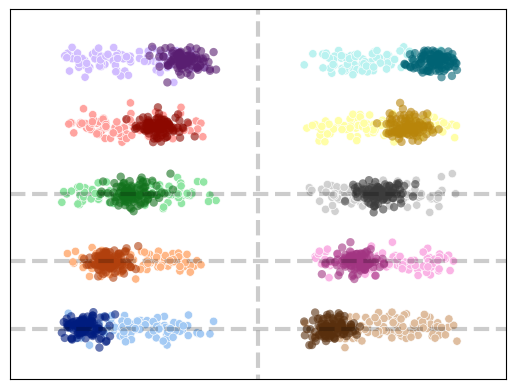

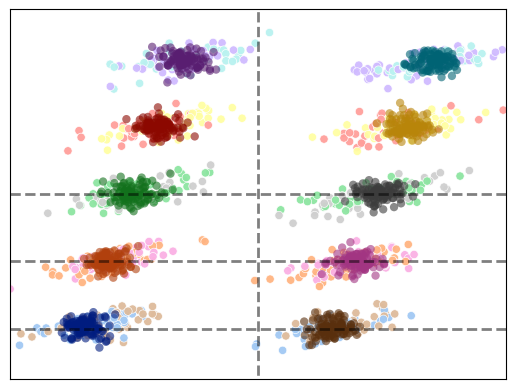

In [11]:
extra_dims = 64
cov = 0
mask_dims = 1

og_varbs = torch.tensor(og_varbs).long()
d = og_varbs.shape[-1] + extra_dims
mask = torch.zeros(d)
mask[:mask_dims] = 1

samples = torch.tensor(samples).float()
noise = torch.randn(len(og_varbs), extra_dims) + cov * torch.randn(len(og_varbs), extra_dims)*og_varbs[:,1:]
natty_varbs = og_varbs.clone()
natty_classes, v2class = get_classes_from_varbs(natty_varbs)
natty_samps = torch.cat([ samples, noise ], dim=-1)
perm = torch.randperm(len(og_varbs)).long()

intrv_varbs = torch.cat([ natty_varbs[:,0:1], natty_varbs[perm,1:] ], dim=-1)
intrv_classes, _ = get_classes_from_varbs(intrv_varbs, v2class=v2class)

trg_vecs = natty_samps[perm].clone()
src_vecs = natty_samps.clone()

eye = torch.nn.Linear(d,d)
eye.weight.data = torch.eye(d).float()
with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, eye, mask)

# Sanity check
quick_plot(
    natty_samps,
    intrv_samps,
    natty_classes=natty_classes,
    intrv_classes=intrv_classes,
    dash_alpha=0.2,
    thickness=3,
    save_name="figs/identity_patching.png",
)

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, rot_mtx, mask)

# Sanity check
quick_plot(natty_samps, intrv_samps, natty_classes=natty_classes, intrv_classes=intrv_classes)


In [12]:
for i,(iv,nv) in enumerate(zip(intrv_varbs,natty_varbs)):
    if tuple(iv.tolist())==tuple(nv.tolist()):
        assert natty_classes[i]==intrv_classes[i]

In [13]:
def train_classifier(
    vecs, classes,
    n_epochs=1000,
    lr=0.01,
    l2=0.01,
    drop_p=0.5,
    bsize=128,
    patience=500,
    print_every=50,
    n_layers=3,
    hidden_dim=256,
    pre_layernorm=False,
    pre_batchnorm=True,
    layernorm=False,
    batchnorm=True,
    model=None,
    ret_best=True,
    verbose=False,
    epoch_prog=False,
):
    """
    vecs: torch tensor (B,D)
    classes: list-like (B,)
    """
    classes = torch.tensor(classes).long()
    d = vecs.shape[-1]
    n = len(set(classes.detach().cpu().tolist()))
    if model is None:
        modules = []
        if pre_layernorm:
            modules.append(torch.nn.LayerNorm(d))
        if pre_batchnorm:
            modules.append(torch.nn.BatchNorm1d(d))
        if n_layers>2:
            modules += [
                torch.nn.Linear(d,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(drop_p),
            ]
            if layernorm:
                modules.append( torch.nn.LayerNorm(hidden_dim) )
            if batchnorm:
                modules.append( torch.nn.BatchNorm1d(hidden_dim) )
            d = hidden_dim
        if n_layers>1:
            modules += [
                torch.nn.Linear(d,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(drop_p),
            ]
            if layernorm:
                modules.append( torch.nn.LayerNorm(hidden_dim) )
            if batchnorm:
                modules.append( torch.nn.BatchNorm1d(hidden_dim) )
            d = hidden_dim
        modules.append(torch.nn.Linear(d,n))
        model = torch.nn.Sequential(*modules)
    if verbose:
        print(model)
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    optim.zero_grad()

    d = vecs.shape[-1]
    tlen = int(len(vecs)*0.8)
    train_vecs = vecs[:tlen]
    train_classes = classes[:tlen]
    valid_vecs = vecs[tlen:]
    valid_classes = classes[tlen:]
    prev_loss = np.inf
    best_loss = 0
    best_valid_loss = 0
    best_train_acc = 0
    best_valid_acc = 0
    n_pat = 0
    rng = range(n_epochs)
    if epoch_prog and not verbose:
        rng = tqdm(rng)
    for epoch in rng:
        model.train()
        perm = torch.randperm(len(train_vecs)).long()
        for b in range(0,max(len(perm)-bsize+1, 1),bsize):
            idxs = perm[b:b+bsize]
            inputs = train_vecs[idxs]
            labels = train_classes[idxs]
            preds = model(inputs)
            loss = torch.nn.functional.cross_entropy(preds, labels)
            loss.backward()
            optim.step()
            optim.zero_grad()
        with torch.no_grad():
            preds = model(train_vecs)
            train_acc = (preds.argmax(-1)==train_classes).float().mean()
            model.eval()
            preds = model(valid_vecs)
            valid_acc = (preds.argmax(-1)==valid_classes).float().mean()
            valid_loss = torch.nn.functional.cross_entropy(preds, valid_classes)
        if epoch % print_every == 0 and verbose:
            print(epoch,
                  "TrnLoss:", loss.item(),
                  "ValLoss:", valid_loss.item(),
                  "TrnAcc:", train_acc.item(),
                  "ValAcc:", valid_acc.item()
                )
        if valid_acc>best_valid_acc or (valid_acc>=best_valid_acc and train_acc>best_train_acc):
            best_loss = loss
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            best_train_acc = train_acc
            best_model = copy.deepcopy(model)
        if valid_loss>=prev_loss:
            n_pat += 1
            if n_pat>=patience:
                print("Converged at epoch", epoch)
                break
        prev_loss = valid_loss.item()
        
    model.eval()
    if ret_best:
        print(epoch,
              "TrnLoss:", best_loss.item(),
              "ValLoss:", best_valid_loss.item(),
              "TrnAcc:", best_train_acc.item(),
              "ValAcc:", best_valid_acc.item()
            )
        return best_model, best_train_acc.item(), best_valid_acc.item()
    print(epoch,
          "TrnLoss:", loss.item(),
          "ValLoss:", valid_loss.item(),
          "TrnAcc:", train_acc.item(),
          "ValAcc:", valid_acc.item()
        )
    return model, train_acc.item(), valid_acc.item()

In [14]:
def get_cl_vectors(natty_varbs, intrv_varbs, natty_vecs, method="sample", varb_idx=None):
    """
    natty_varbs: tensor (B,2)
        the non-noisy variable values
    intrv_varbs: tensor (B,2)
        the non-noisy variable values
    natty_vecs: tensor (B,D)
        the noisy native vector representations
    method: str
        options: sample, mean
        determines whether the cl vectors should be averaged
        over all possible candidates or individual samples
    """
    cl_vectors = []
    all_idxs = torch.arange(len(natty_varbs)).long()
    for intrv in intrv_varbs:
        if varb_idx is None:
            valid_bools = (natty_varbs[:,0]==intrv[0])&(natty_varbs[:,1]==intrv[1])
        else:
            valid_bools = (natty_varbs[:,varb_idx]==intrv[varb_idx])
        valid_idxs = all_idxs[valid_bools]
        if method=="sample":
            idx = valid_idxs[int(np.random.randint(len(valid_idxs)))]
            cl_vectors.append(natty_vecs[idx])
        elif method in {"average", "mean"}:
            cl_vectors.append(natty_vecs[valid_idxs].mean(0))
    return torch.vstack(cl_vectors)

In [15]:
def calc_cl_loss(intrv, cl, cl_loss_type="both"):
    l2,cos = 0,0
    if cl_loss_type in {"mse", "both"}:
        l2 = ((intrv-cl)**2).mean()
    if cl_loss_type in {"cos", "both"}:
        cos = 1-torch.nn.functional.cosine_similarity(intrv,cl)
    return l2 + cos
    
def get_cl_loss(
    trg, src,
    mtx, mask,
    cl_vecs,
    empty_mask=None,
    incl_extra=True,
    n_varbs=2,
    calc_loss_in_aligned_basis=False,
    detach_cl_vecs=False,
    cl_loss_type="both",
    cl_1d=False,
    cl_varb_idxs=None,
):
    """
    Performs the interchange and computes the cl loss
    
    Args:
        trg: tensor (B,D)
            target vectors which will be patched into
        src: tensor (B,D)
            source vectors from which activity will be harvested
        mtx: torch module
            must have attribute "weight"
        cl_vecs: tensor (B,D)
        incl_extra: bool
            if true, the extraneous dimensions are included in
            the CL loss
        n_varbs: int
            the number of variables in the causal abstraction
        calc_loss_in_aligned_basis: bool
            if true, will compute cl loss in aligned basis
        detach_cl_vecs: bool
            if true, will detach the cl vectors from gradient
            calculations. otherwise, their rotation will be
            included in the loss.
        cl_loss_type: str
            options:
                "cos": cosine loss only
                "mse": mse loss only
                "both": add both cos and mse losses and divide by 2
        cl_1d: bool
            if true, will split the data and calculate the cl
            loss only along individual causal dimensions. Only
            applies if incl_extra is false.
        cl_varb_idxs: None or torch long tensor (B,)
            optionally specify the causal variable to use in the
            cl loss.
    """
    intrv = interchange(trg, src, mtx, mask)
    if empty_mask is not None:
        perm = torch.randperm(len(src)).long()
        intrv = interchange(intrv, src[perm], mtx, empty_mask)
        
    raw_intrv = intrv.clone()
    extra_dim = mask.long().sum()*n_varbs
    intrv = rot_fwd(intrv, mtx)
    cl_vecs = rot_fwd(cl_vecs, mtx)
    if not incl_extra:
        intrv[:,extra_dim:] = 0
        cl_vecs[:,extra_dim:] = 0
    
    # Isolate individual causal dimensions
    if cl_1d:
        dim1 = mask.long().sum()
        if cl_varb_idxs is not None:
            rows = torch.arange(len(intrv)).long()
            bools = cl_varb_idxs==0
            varb1_rows = rows[bools]
            varb2_rows = rows[~bools]
            intrv[varb1_rows,dim1:extra_dim] = 0
            intrv[varb2_rows,:dim1] = 0
            cl_vecs[varb1_rows,dim1:extra_dim] = 0
            cl_vecs[varb2_rows,:dim1] = 0
        else:
            half = len(intrv)//2
            intrv[:half,:dim1] = 0
            intrv[half:,dim1:extra_dim] = 0
            cl_vecs[:half,:dim1] = 0
            cl_vecs[half:,dim1:extra_dim] = 0
    if not calc_loss_in_aligned_basis:
        intrv = rot_bck(intrv, mtx)
        cl_vecs = rot_bck(cl_vecs, mtx)
    if detach_cl_vecs:
        cl_vecs = cl_vecs.detach().data
    return calc_cl_loss(intrv, cl_vecs, cl_loss_type=cl_loss_type).mean(), raw_intrv
    


In [16]:
def get_actn_loss(preds, labels):
    device = preds.get_device()
    if device<0: device = "cpu"
    labels = torch.tensor(labels).long().to(device)
    loss = torch.nn.functional.cross_entropy(preds, labels)
    acc = (preds.argmax(-1)==labels).float().mean()
    return loss, acc

### Training Loop

In [17]:
def prep_data(
    og_varbs,
    samples,
    v2class=None,
    extra_dims = 128, # total number of additional noise dimensions
    dupl_rank = 0, # number of additional dimensions that are exact duplicates
    zero_rank = 0, # number of dimensions to zero out
    mask_dims=1, # number of dimensions in the DAS mask
    cov_strength = 1, # how much do the extraneous dimensions covary with the x and y values,
    n_samples_per_class=None,
    normalize=False,
):
    """
    Constructs the dataset from the samples
    """
    dupl_rank = min(extra_dims-1, dupl_rank)
    
    d = og_varbs.shape[-1] + extra_dims
    mask = torch.zeros(d)
    mask[:mask_dims] = 1

    if extra_dims>0:
        n_noise_dims = extra_dims-dupl_rank
        if extra_dims>1:
            noise = torch.randn(len(og_varbs), n_noise_dims) +\
                torch.cat([
                    cov_strength * torch.randn(len(og_varbs), n_noise_dims//2)*og_varbs[:,1:],
                    cov_strength * torch.randn(len(og_varbs), n_noise_dims//2)*og_varbs[:,0:1]
                ],dim=-1)
        else:
            noise = torch.randn(len(og_varbs), n_noise_dims) + cov_strength * torch.randn(len(og_varbs), n_noise_dims)*og_varbs[:,1:]
            
        if dupl_rank>0:
            idxs = torch.randint(0,noise.shape[-1],(dupl_rank,)).long()
            dupls = noise.T[idxs].T
            noise = torch.cat([noise,dupls],dim=-1)
        if zero_rank>0:
            # Instead of just zeroing out dimensions, we reduce the rank of the noise
            # in a rotated basis.
            n = noise.shape[-1]
            orth = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(n,n))
            with torch.no_grad():
                noise = torch.matmul(noise, orth.weight)
                noise[:,:zero_rank] = 0
                noise = torch.matmul(noise, orth.weight.T)
        natty_vecs = torch.cat([
            torch.tensor(samples).float(), noise
        ], dim=-1)
    else: natty_vecs = torch.tensor(samples).float()
    natty_varbs = torch.tensor(og_varbs).long()
    natty_classes, v2class = get_classes_from_varbs(natty_varbs, v2class=v2class)
    natty_classes = torch.tensor(natty_classes).long()
    if normalize:
        natty_vecs = (natty_vecs-natty_vecs.mean(0))/natty_vecs.std()

    if not n_samples_per_class or n_samples_per_class<0:
        perm = torch.randperm(len(og_varbs)).long()
        intrv_idxs = torch.stack([
            torch.arange(len(og_varbs)).long(), perm
        ],dim=1)
    
        intrv_varbs = torch.cat([ natty_varbs[:,0:1], natty_varbs[perm,1:] ], dim=-1)
        intrv_classes, intrv_v2class = get_classes_from_varbs(intrv_varbs, v2class={**v2class})
        intrv_classes = torch.tensor(intrv_classes).long()
        if len(intrv_v2class)!=len(v2class):
            valid_intrvs = torch.isin(intrv_classes, torch.tensor(list(v2class.values())).long())
        else:
            valid_intrvs = torch.ones(len(intrv_classes)).bool()

        trg_vecs = natty_vecs[perm].clone()
        src_vecs = natty_vecs.clone()
    else:
        intrv_v2class = {**v2class}
        c2varb = {v:k for k,v in v2class.items()}
        n_classes = len(v2class)
        intrv_classes = []
        intrv_idxs = []
        intrv_varbs = []
        arange = torch.arange(len(natty_varbs)).long()
        for c,varb_tup in c2varb.items():
            for samp in range(n_samples_per_class):
                idxs1 = arange[(natty_varbs[:,0]==varb_tup[0])]
                idx1 = idxs1[int(np.random.randint(len(idxs1)))]
                idxs2 = arange[(natty_varbs[:,1]==varb_tup[1])]
                idx2 = idxs2[int(np.random.randint(len(idxs2)))]
                intrv_idxs.append([int(idx1),int(idx2)])
                intrv_classes.append(c)
                intrv_varbs.append([varb_tup[0], varb_tup[1]])
                assert natty_varbs[idx1,0]==varb_tup[0] and natty_varbs[idx2,1]==varb_tup[1]
        intrv_idxs = torch.tensor(intrv_idxs).long()
        intrv_classes = torch.tensor(intrv_classes).long()
        intrv_varbs = torch.tensor(intrv_varbs).long()
        valid_intrvs = torch.ones(len(intrv_classes)).bool()
        
        trg_vecs = natty_vecs[intrv_idxs[:,1]].clone()
        src_vecs = natty_vecs[intrv_idxs[:,0]].clone()
        natty_varbs = natty_varbs[intrv_idxs[:,0]]
        natty_classes = natty_classes[intrv_idxs[:,0]]
        natty_vecs = src_vecs.clone()
                             
    return {
        "intrv_idxs": intrv_idxs,
        
        "mask": mask.clone(),
        "src_vecs": src_vecs.clone(),
        "trg_vecs": trg_vecs.clone(),
        "intrv_varbs": intrv_varbs.clone(),
        "intrv_classes": intrv_classes.clone(),
        "valid_intrvs": valid_intrvs.clone(),
        "src_varbs": natty_varbs.clone(),
        "intrv_v2class": intrv_v2class,
        "src_classes": natty_classes.clone(),
        "v2class": v2class,
    }

In [18]:
def get_plot_save_name(params, excl_keys={"calc_loss_in_aligned_basis", "lr", "n_epochs", "detach_cl_vecs"}):
    s = "toydiv"
    for k in sorted(list(params.keys())):
        if k in excl_keys: continue
        v = params[k]
        s+= f"_{k}{v}"
    return s+".png"

In [19]:
import copy

def train_rotation(
    src_varbs, intrv_varbs, classifier,
    trg_vecs, src_vecs,
    src_classes, intrv_classes,
    mask=None,
    n_epochs = 1000,
    lr = 0.01,
    cl_eps = 1,
    cl_loss_type="both",#"cos" "mse" "both"
    cl_1d=False, # use the 1d cl vector objective
    method = "mean",  #"mean" "sample"
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = False,
    incl_actn_loss = False,
    incl_cl_loss = True,
    mtx_type = "orthog", # "orthog" "linear",
    print_every = 50,
    fig_every = 200,
    save_fig=False,
    shuffle_empty=False,
    incl_dividers=False,
    early_stopping=True,
    early_stop_thresh=1e-5,
    early_stop_patience=100,
    rot_dtype="float",
    **kwargs,
):
    exp_params = {
        "n_epochs": n_epochs,
        "lr": lr,
        "method": method,
        "incl_extra": incl_extra,
        "calc_loss_in_aligned_basis": calc_loss_in_aligned_basis,
        "detach_cl_vecs": detach_cl_vecs,
        "incl_actn_loss": incl_actn_loss,
        "incl_cl_loss": incl_cl_loss,
        "mtx_type": mtx_type,
        "cl_eps": cl_eps,
    }
    print("Actn Loss:", incl_actn_loss)
    print("CL Loss:", incl_actn_loss)

    d = src_vecs.shape[-1]
    assert incl_actn_loss or incl_cl_loss
    if cl_1d:
        perm = torch.randperm(len(src_varbs)).long()
        half = len(src_varbs)//2
        cl_vecs = torch.empty_like(src_vecs)
        cl_varb_idxs = torch.zeros(len(src_varbs)).long()
        cl_varb_idxs[perm[half:]] = 1
        cl_vecs[perm[:half]] = get_cl_vectors(
            src_varbs[perm[:half]],
            intrv_varbs[perm[:half]],
            src_vecs[perm[:half]],
            method=method,
            varb_idx=0
        )
        cl_vecs[perm[half:]] = get_cl_vectors(
            src_varbs[perm[half:]],
            intrv_varbs[perm[half:]],
            src_vecs[perm[half:]],
            method=method,
            varb_idx=1
        )
    else:
        cl_varb_idxs = None
        cl_vecs = get_cl_vectors(src_varbs, intrv_varbs, src_vecs, method=method)
    if mask is None:
        mask = torch.zeros(d)
        mask[:1] = 1
    empty_mask = None
    if shuffle_empty:
        empty_mask = torch.zeros_like(mask).cuda()
        empty_mask[int(mask.long().sum())*2:] = 1

    # eye = torch.nn.Linear(d,d)
    # eye.weight.data = torch.eye(d).float()
    # rot_mtx = eye
    if mtx_type=="linear":
        rot_mtx = SymmetricDefiniteMatrix( size=d, )
    elif "orthog" in mtx_type:
        rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))
    else:
        raise NotImplemented
    if rot_dtype=="double":
        rot_mtx.double()
    optim = torch.optim.Adam(rot_mtx.parameters(), lr=lr)
    optim.zero_grad()

    with torch.no_grad():
        eye = torch.nn.Linear(d,d)
        eye.weight.data = torch.eye(d).float()
        intrv_vecs = interchange(trg_vecs, src_vecs, eye, mask)
    #quick_plot(intrv_vecs, src_vecs, intrv_classes, src_classes, )
    if fig_every<np.inf:
        print("Identity")
        quick_plot(
            src_vecs, intrv_vecs.detach(),
            src_classes, intrv_classes,
            save_name="figs/identity.png",
            incl_dividers=incl_dividers
        )
        if incl_cl_loss:
            print("CL Vectors")
            quick_plot(
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                intrv_classes, intrv_classes,
                incl_dividers=incl_dividers
            )

    with torch.no_grad():
        intrv_vecs = interchange(trg_vecs, src_vecs, rot_mtx, mask)
    #quick_plot(intrv_vecs, src_vecs, intrv_classes, src_classes, )
    if fig_every<np.inf:
        print("Untrained")
        quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, incl_dividers=incl_dividers)

    print("Training Rotation")
    n_pat = 0
    best_acc = 0
    best_loss = np.inf
    best_emd = np.inf
    best_row_emd = np.inf
    bestemd_row_emd = np.inf
    bestloss_loss = np.inf
    for epoch in range(n_epochs):
        cl_loss, intrv_vecs = get_cl_loss(
            trg=trg_vecs.cuda(),
            src=src_vecs.cuda(),
            mtx=rot_mtx.cuda(),
            mask=mask.cuda(),
            empty_mask=empty_mask,
            cl_vecs=cl_vecs.cuda(),
            incl_extra=incl_extra,
            calc_loss_in_aligned_basis=calc_loss_in_aligned_basis,
            detach_cl_vecs=detach_cl_vecs,
            cl_loss_type=cl_loss_type,
            cl_1d=cl_1d,
            cl_varb_idxs=cl_varb_idxs,
        )
        with torch.no_grad():
            perm = torch.randperm(len(src_vecs)).long()
            emd = compute_emd(src_vecs[perm].cuda(), intrv_vecs.cuda()).item()
            extra_mask = torch.zeros_like(mask).cuda()
            extra_mask[:2] = 1 # Only using the causal dimensions
            row_emd = compute_emd(
                intrv_vecs.cuda()*extra_mask, src_vecs.cuda()*extra_mask
            ).item()
            
        actn_loss, acc = get_actn_loss(classifier(intrv_vecs), intrv_classes)
        loss = 0
        if incl_actn_loss:
            loss += actn_loss
        if incl_cl_loss:
            loss += cl_eps*cl_loss
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        if epoch % print_every == 0:
            print(epoch, "Cl Loss:", cl_loss.item(), "ActLoss:", actn_loss.item(), "Actn:", acc.item(), "EMD:", emd, "RowEMD", row_emd)
        if epoch % fig_every == 0 and epoch > 0:
            quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, incl_dividers=incl_dividers)
            
        if acc>best_acc:
            best_acc = acc
            best_mtx = copy.deepcopy(rot_mtx)
            best_cl_loss = cl_loss
            best_actn_loss = actn_loss
            best_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            best_emd = emd
            best_row_emd = row_emd
        if loss<bestloss_loss:
            bestloss_acc = acc
            bestloss_loss = loss.item()
            bestloss_mtx = copy.deepcopy(rot_mtx)
            bestloss_cl_loss = cl_loss
            bestloss_actn_loss = actn_loss
            bestloss_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            bestloss_emd = emd
            bestloss_row_emd = row_emd
        if row_emd<bestemd_row_emd:
            bestemd_row_emd = row_emd
            bestemd_emd = emd
            bestemd_loss = loss.item()
            bestemd_mtx = copy.deepcopy(rot_mtx)
            bestemd_cl_loss = cl_loss
            bestemd_actn_loss = actn_loss
            bestemd_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            bestemd_acc = acc
            
        if loss>=(bestloss_loss-early_stop_thresh) and early_stopping:
            n_pat += 1
            if n_pat>early_stop_patience:
                print("Converged at epoch", epoch)
                break
        else:
            n_pat = 0
        if acc.item()==1 and early_stopping and epoch>=early_stop_patience:
            print("Converged at epoch", epoch)
            break


    for p in sorted(list(exp_params.keys())):
        print(p, exp_params[p])
    print()
    if fig_every<np.inf or save_fig:
        save_name = "figs/"+get_plot_save_name(exp_params)
        print("Best Checkpt (by Train Acc)")
        quick_plot(
            src_vecs, best_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name if save_fig else None,
            incl_dividers=incl_dividers,
        )
        print("Best Checkpt (by Train Loss)")
        quick_plot(
            src_vecs, bestloss_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name if save_fig else None,
            incl_dividers=incl_dividers,
        )
        print("Best Checkpt (by EMD)")
        quick_plot(
            src_vecs, bestemd_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name if save_fig else None,
            incl_dividers=incl_dividers,
        )
        print("Last Checkpt")
        quick_plot(
            src_vecs, intrv_vecs,
            src_classes, intrv_classes,
            incl_dividers=incl_dividers,
        )
    print(epoch,
        "Cl Loss:", best_cl_loss.item(),
          "ActLoss:", best_actn_loss.item(),
          "Actn:", best_acc.item(),
          "EMD:", best_emd,
         "RowEMD:", best_row_emd)
    best_metrics = {
        "cl_loss": best_cl_loss,
        "actn_loss": best_actn_loss,
        "acc": best_acc,
        "emd": best_emd,
        "row_emd": best_row_emd,
        "mtx": best_mtx,
    }
    bestloss_metrics = {
        "cl_loss": bestloss_cl_loss,
        "actn_loss": bestloss_actn_loss,
        "acc": bestloss_acc,
        "emd": bestloss_emd,
        "row_emd": bestloss_row_emd,
        "mtx": bestloss_mtx,
    }
    bestemd_metrics = {
        "cl_loss": bestemd_cl_loss,
        "actn_loss": bestemd_actn_loss,
        "acc": bestemd_acc,
        "emd": bestemd_emd,
        "row_emd": bestemd_row_emd,
        "mtx": bestemd_mtx,
    }
    ret_dict = {
        "last_mtx": rot_mtx,
        "exp_params": exp_params,
        "best_metrics": best_metrics,
        "bestloss_metrics": bestloss_metrics,
        "bestemd_metrics": bestemd_metrics,
    }
    return ret_dict


/tmp/ipykernel_1348040/2731878652.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Identity
Div: tensor(0.0573)


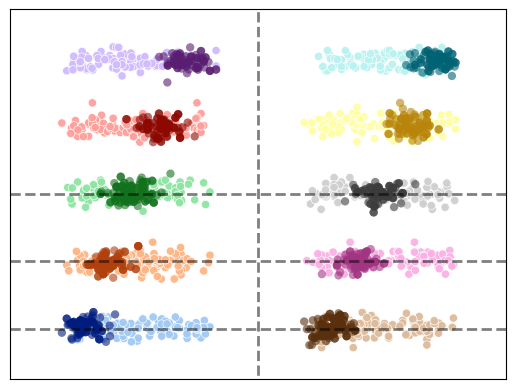

Untrained
Div: tensor(0.1871)


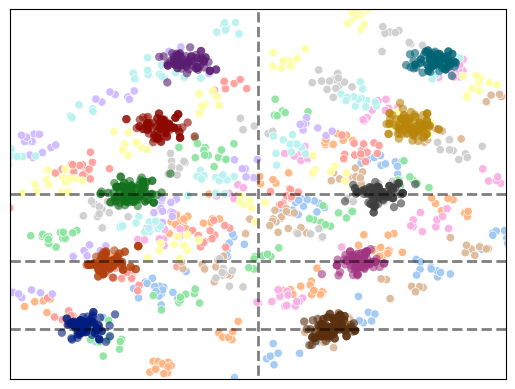

In [20]:
extra_dims = 0
dupl_rank = 0 # duplicates uniformly sampled extra dimensions from the set of extra_dims-dupl_rank noisy dimensions
zero_rank = 0
mask_dims = 1
cov_strength = 0 # how much do the extraneous dimensions covary with the x and y values
normalize = False

np.random.seed(12345)
torch.manual_seed(12345)

data_dict = prep_data(
    og_varbs=og_varbs,
    samples=samples,
    v2class=v2class,
    extra_dims=extra_dims,
    dupl_rank=dupl_rank,
    zero_rank=zero_rank,
    mask_dims=mask_dims,
    cov_strength=cov_strength,
    n_samples_per_class=100,
    normalize=normalize
)

mask = data_dict["mask"]
valids = data_dict["valid_intrvs"]
src_vecs = data_dict["src_vecs"][valids]
trg_vecs = data_dict["trg_vecs"][valids]
intrv_idxs = data_dict["intrv_idxs"][valids]
intrv_varbs = data_dict["intrv_varbs"][valids]
intrv_classes = data_dict["intrv_classes"][valids]
src_classes = data_dict["src_classes"][valids]
src_varbs = data_dict["src_varbs"][valids]


d = src_vecs.shape[-1]
mask = torch.zeros(d)
mask[:mask_dims] = 1
empty_mask = torch.zeros_like(mask)
if len(mask)>mask_dims*2:
    empty_mask[mask_dims*2:] = 1

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    eye = torch.nn.Linear(d,d)
    eye.weight.data = torch.eye(d).float()
    intrv_vecs = interchange(trg_vecs, src_vecs, eye, mask)
print("Identity")
div = compute_emd(src_vecs, intrv_vecs)
print("Div:", div)
quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, )

with torch.no_grad():
    intrv_vecs = interchange(trg_vecs, src_vecs, rot_mtx, mask)
print("Untrained")
div = compute_emd(src_vecs, intrv_vecs)
print("Div:", div)
quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, )


In [21]:
lr = 0.01
bsize = 200
patience = 100
l2 = 0.005
n_epochs = 1000
drop_p = 0.5
hidden_dim = 128
n_layers = 2 # 1-3 layers 
pre_layernorm = False
pre_batchnorm = True
layernorm = False
batchnorm = True

np.random.seed(12345)
torch.manual_seed(12345)
print("Training Classifier")
classifier, max_acc, _ = train_classifier(
    #normalize_fn(src_vecs),
    src_vecs,
    src_classes,
    lr=lr,
    patience=patience,
    l2=l2,
    hidden_dim=hidden_dim,
    n_epochs=n_epochs,
    drop_p=drop_p,
    bsize=bsize,
    n_layers=n_layers,
    pre_layernorm=pre_layernorm,
    pre_batchnorm=pre_batchnorm,
    layernorm=layernorm,
    batchnorm=batchnorm,
    #model=model,
    ret_best=True,
    verbose=True,
)
classifier.cuda()
classifier.eval()
for p in classifier.parameters():
    p.requires_grad = False

Training Classifier
Sequential(
  (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=2, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=128, out_features=10, bias=True)
)


/tmp/ipykernel_1348040/3855041251.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


0 TrnLoss: 1.191847801208496 ValLoss: 1.3177047967910767 TrnAcc: 0.7112500071525574 ValAcc: 0.6899999976158142
50 TrnLoss: 0.12241693586111069 ValLoss: 0.07209000736474991 TrnAcc: 0.9962499737739563 ValAcc: 1.0
100 TrnLoss: 0.08835959434509277 ValLoss: 0.0679098591208458 TrnAcc: 0.9950000047683716 ValAcc: 1.0
150 TrnLoss: 0.09670829027891159 ValLoss: 0.06468044966459274 TrnAcc: 0.9962499737739563 ValAcc: 1.0
200 TrnLoss: 0.08391770720481873 ValLoss: 0.06793978065252304 TrnAcc: 0.9912499785423279 ValAcc: 1.0
Converged at epoch 209
209 TrnLoss: 0.14232593774795532 ValLoss: 0.07451077550649643 TrnAcc: 1.0 ValAcc: 1.0


Actn Loss: False
CL Loss: False
Identity


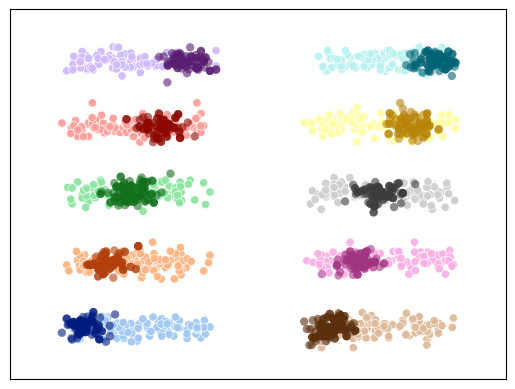

CL Vectors


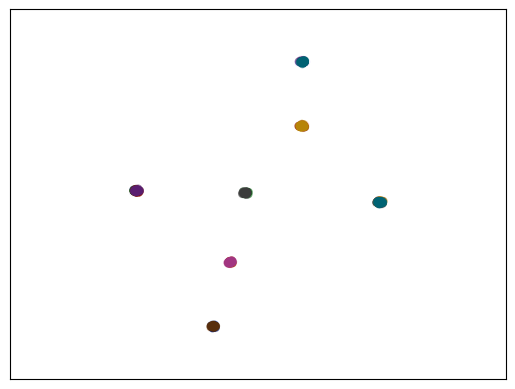

Untrained


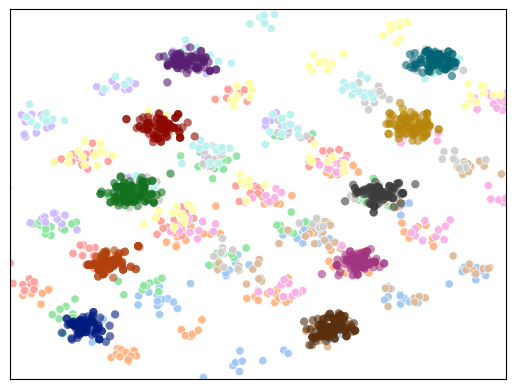

Training Rotation


/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


0 Cl Loss: 0.7884553670883179 ActLoss: 3.7594199180603027 Actn: 0.18800000846385956 EMD: 0.20285668969154358 RowEMD 0.20285670459270477
50 Cl Loss: 0.09364140033721924 ActLoss: 0.0938674733042717 Actn: 1.0 EMD: 0.020769067108631134 RowEMD 0.020769067108631134
100 Cl Loss: 0.10393565893173218 ActLoss: 0.12406297028064728 Actn: 0.9910000562667847 EMD: 0.015363642014563084 RowEMD 0.015363640151917934
150 Cl Loss: 0.10393575578927994 ActLoss: 0.12378928065299988 Actn: 0.9910000562667847 EMD: 0.015367738902568817 RowEMD 0.015367741696536541
200 Cl Loss: 0.10393574833869934 ActLoss: 0.12384262681007385 Actn: 0.9910000562667847 EMD: 0.015366906300187111 RowEMD 0.015366909094154835
250 Cl Loss: 0.10393577069044113 ActLoss: 0.12382327765226364 Actn: 0.9910000562667847 EMD: 0.015367195010185242 RowEMD 0.015367196872830391


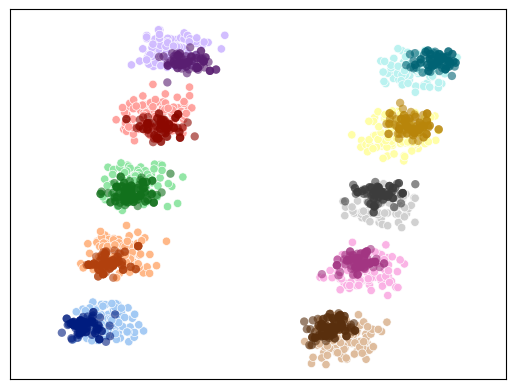

/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


300 Cl Loss: 0.10393577814102173 ActLoss: 0.12382354587316513 Actn: 0.9910000562667847 EMD: 0.015367195010185242 RowEMD 0.015367196872830391
350 Cl Loss: 0.10393576323986053 ActLoss: 0.12382368743419647 Actn: 0.9910000562667847 EMD: 0.015367190353572369 RowEMD 0.015367185696959496
400 Cl Loss: 0.10393576323986053 ActLoss: 0.12382368743419647 Actn: 0.9910000562667847 EMD: 0.015367189422249794 RowEMD 0.015367185696959496
450 Cl Loss: 0.10393576323986053 ActLoss: 0.12382368743419647 Actn: 0.9910000562667847 EMD: 0.015367187559604645 RowEMD 0.015367185696959496
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 500

Best Checkpt (by Train Acc)


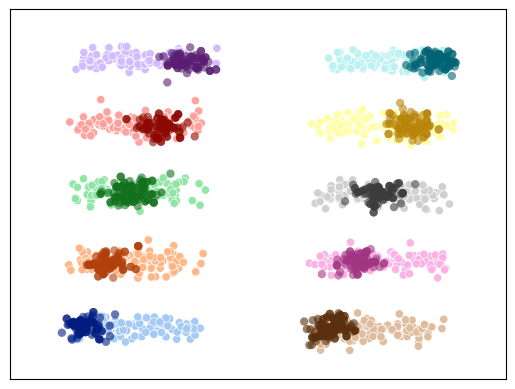

Best Checkpt (by Train Loss)


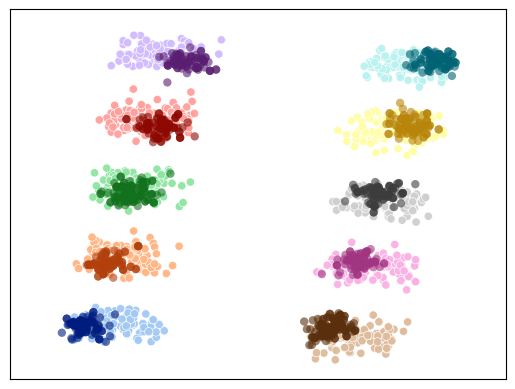

Best Checkpt (by EMD)


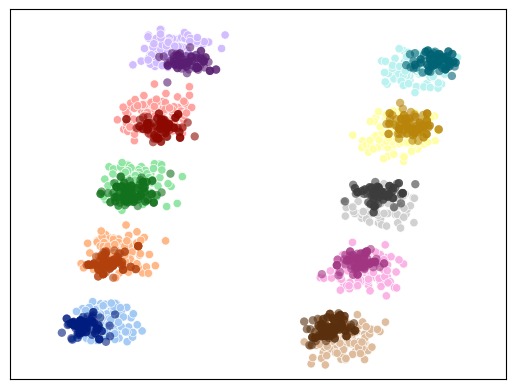

Last Checkpt


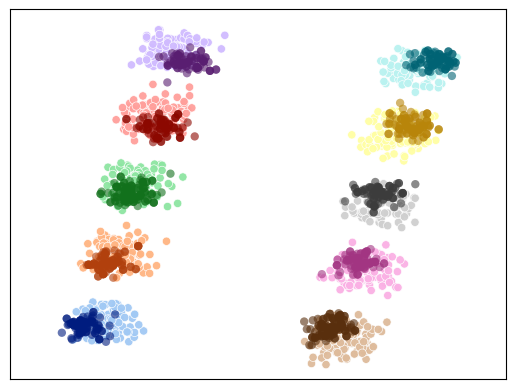

499 Cl Loss: 0.10407182574272156 ActLoss: 0.09240499138832092 Actn: 1.0 EMD: 0.04601367190480232 RowEMD: 0.04601367190480232


In [22]:
# Run the CL Loss only
lr = 0.05
cl_eps = 100
mask_dims = 1
n_epochs = 500
fig_every = 250
mtx_type = "orthog" # "orthog" "linear",
cl_1d = True
rot_dtype = "float"

d = src_vecs.shape[-1]
mask = torch.zeros(d)
mask[:mask_dims] = 1

np.random.seed(12345)
torch.manual_seed(12345)
ret_dict = train_rotation(
    src_varbs=src_varbs,
    intrv_varbs=intrv_varbs,
    classifier=classifier,
    trg_vecs=trg_vecs,
    src_vecs=src_vecs,
    src_classes=src_classes,
    intrv_classes=intrv_classes,
    mask=mask,
    cl_loss_type = "both", #"cos", "mse", "both
    method = "mean",  #"mean" "sample"
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = True,
    shuffle_empty = False,
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    cl_1d = cl_1d,
    rot_dtype=rot_dtype,
    lr = lr,
    cl_eps=cl_eps,
    early_stopping=False,
    incl_actn_loss = False,
    incl_cl_loss = True,
    mtx_type = mtx_type, # "orthog" "linear",
    print_every = 50,
    n_epochs = n_epochs,
    fig_every = fig_every,
    save_fig=True,
    incl_dividers=False,
)

Actn Loss: True
CL Loss: True
Identity


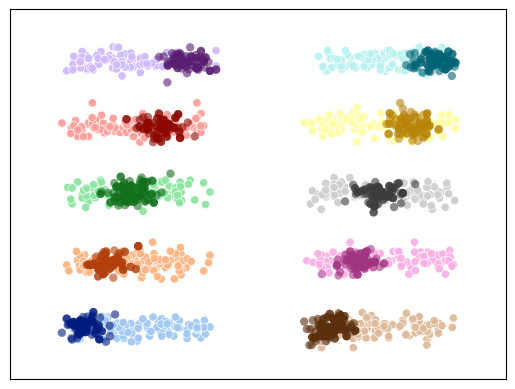

Untrained


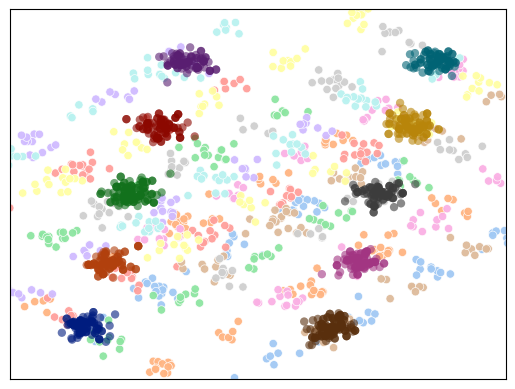

Training Rotation
0 Cl Loss: 2.7110133171081543 ActLoss: 4.679357528686523 Actn: 0.12400000542402267 EMD: 0.18713830411434174 RowEMD 0.18713831901550293


/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


50 Cl Loss: 0.10859764367341995 ActLoss: 0.09699884802103043 Actn: 1.0 EMD: 0.052630942314863205 RowEMD 0.0526309460401535
100 Cl Loss: 0.07423287630081177 ActLoss: 0.08761241286993027 Actn: 1.0 EMD: 0.032372165471315384 RowEMD 0.032372165471315384
150 Cl Loss: 0.07325951755046844 ActLoss: 0.08759797364473343 Actn: 1.0 EMD: 0.031790051609277725 RowEMD 0.031790055334568024
200 Cl Loss: 0.07307901233434677 ActLoss: 0.08759760856628418 Actn: 1.0 EMD: 0.03168202191591263 RowEMD 0.03168202191591263
250 Cl Loss: 0.07306163012981415 ActLoss: 0.08759760111570358 Actn: 1.0 EMD: 0.031671613454818726 RowEMD 0.03167162463068962


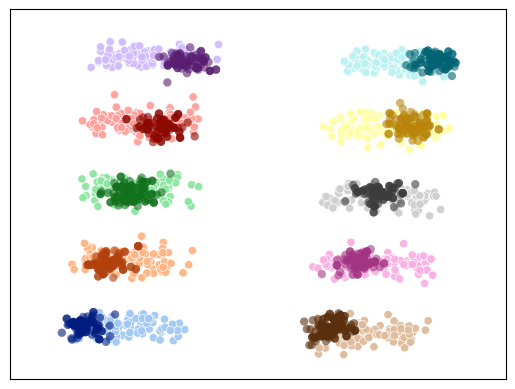

/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


300 Cl Loss: 0.07306027412414551 ActLoss: 0.08759763836860657 Actn: 1.0 EMD: 0.03167080134153366 RowEMD 0.03167080506682396
350 Cl Loss: 0.07306017726659775 ActLoss: 0.08759763091802597 Actn: 1.0 EMD: 0.03167074918746948 RowEMD 0.03167074918746948
400 Cl Loss: 0.07306017726659775 ActLoss: 0.08759763091802597 Actn: 1.0 EMD: 0.031670745462179184 RowEMD 0.03167074918746948
450 Cl Loss: 0.07306017726659775 ActLoss: 0.08759763091802597 Actn: 1.0 EMD: 0.03167074918746948 RowEMD 0.03167074918746948
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 500

Best Checkpt (by Train Acc)


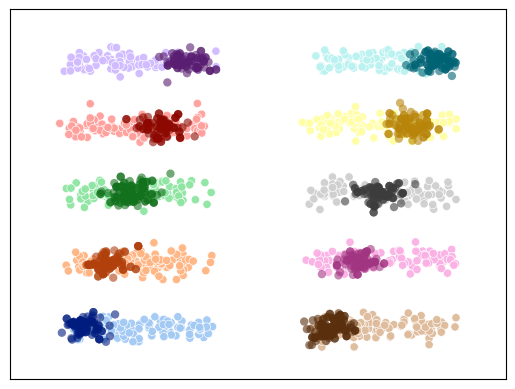

Best Checkpt (by Train Loss)


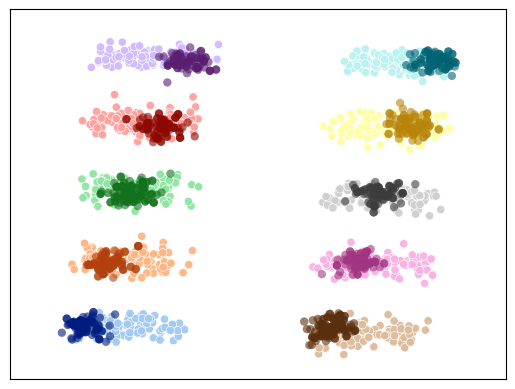

Best Checkpt (by EMD)


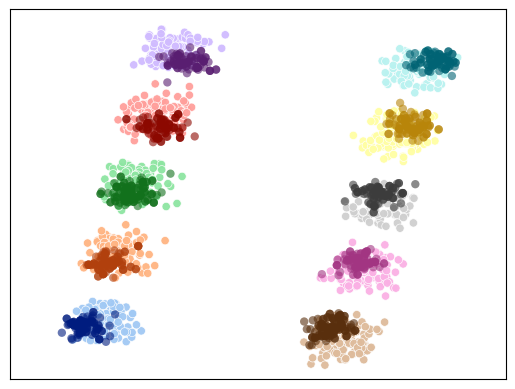

Last Checkpt


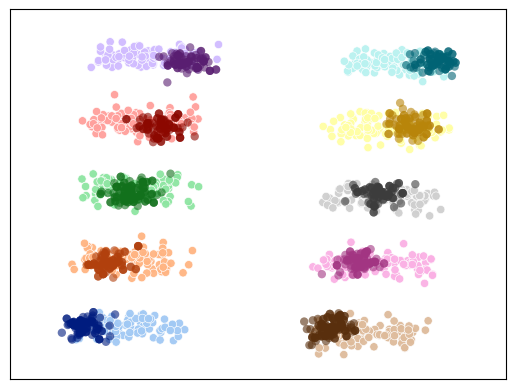

499 Cl Loss: 0.12226401269435883 ActLoss: 0.10403428971767426 Actn: 1.0 EMD: 0.06048281118273735 RowEMD: 0.06048280745744705


In [23]:
# Run the behavioral loss only
np.random.seed(12345)
torch.manual_seed(12345)
ret_dict = train_rotation(
    src_varbs=src_varbs,
    intrv_varbs=intrv_varbs,
    classifier=classifier,
    trg_vecs=trg_vecs,
    src_vecs=src_vecs,
    src_classes=src_classes,
    intrv_classes=intrv_classes,
    mask=mask,
    cl_loss_type = "both", #"cos", "mse", "both
    method = "mean",  #"mean" "sample"
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = True,
    shuffle_empty = False,
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    lr = lr,
    cl_eps=cl_eps,
    early_stopping=False,
    incl_actn_loss = True,
    incl_cl_loss = False,
    mtx_type = "orthog", # "orthog" "linear",
    print_every = 50,
    n_epochs = n_epochs,
    fig_every = fig_every,
    save_fig=True,
    incl_dividers=False,
)


# Multi Tasking

In [24]:
def test_rotation(
        rot_mtx,
        data,
        classifier,
        mask=None,
        incl_extra=False,
        calc_loss_in_aligned_basis=False,
        detach_cl_vecs=False,
        method="mean",
        ylim=[-2.75,1.75],
        fig_save_name=None,
        **kwargs,
):
    cl_vecs = get_cl_vectors(
        data["src_varbs"], data["intrv_varbs"], data["src_vecs"], method=method
    )
    if mask is None:
        mask = torch.zeros(src_vecs.shape[-1]).cuda()
        mask[0] = 1

    cl_loss, intrv_vecs = get_cl_loss(
        trg=data["trg_vecs"].cuda(),
        src=data["src_vecs"].cuda(),
        mtx=rot_mtx.cuda(),
        mask=mask.cuda(),
        cl_vecs=cl_vecs.cuda(),
        incl_extra=incl_extra,
        calc_loss_in_aligned_basis=calc_loss_in_aligned_basis,
        detach_cl_vecs=detach_cl_vecs,
    )
    with torch.no_grad():
        src_vecs = data["src_vecs"]
        perm = torch.randperm(len(src_vecs)).long()
        emd = compute_emd(src_vecs[perm].cuda(), intrv_vecs.cuda()).item()
        extra_mask = torch.zeros_like(mask).cuda()
        extra_mask[:2] = 1 # Only using the causal dimensions
        row_emd = compute_emd(
            intrv_vecs.cuda()*extra_mask, src_vecs.cuda()*extra_mask
        ).item()
    actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())

    print("Cl Loss:", cl_loss.item(), "ActLoss:", actn_loss.item(), "Actn:", acc.item(), "EMD:", emd, "RowEMD:", row_emd)
    quick_plot(
        data["src_vecs"], intrv_vecs.detach(),
        data["src_classes"], data["intrv_classes"],
        ylim=ylim,
        incl_dividers=False,
        save_name=fig_save_name,
    )
    return cl_loss, actn_loss, acc, emd, row_emd

### Task Exploration

In [25]:
import time
from toytask_utils import all_divisions
from datetime import datetime

In [26]:
divisions = all_divisions
divisions

['shared_y',
 'shared_y_overlap',
 'tetris_L',
 'mirror_L',
 'tetris_T',
 'tetris_T_no_overlap',
 'tetris_C',
 'tetris_h',
 'mirror_h',
 'tetris_F',
 'mirror_F',
 'random',
 'random_overlap',
 'inner_square',
 'xor',
 'distinct_xy_overlap',
 'distinct_xy',
 'distinct_y_overlap',
 'distinct_y']

11-11-2025_10H55M
Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


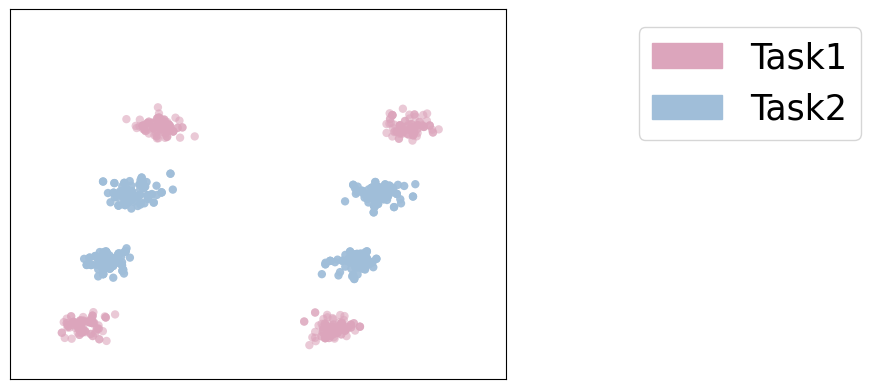

/tmp/ipykernel_1348040/3855041251.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 46%|█████████████████████████████████████████████████████████████████                                                                            | 461/1000 [00:01<00:01, 406.09it/s]


Converged at epoch 461
461 TrnLoss: 0.04397664591670036 ValLoss: 0.10071662813425064 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 43%|████████████████████████████████████████████████████████████                                                                                 | 426/1000 [00:01<00:01, 406.90it/s]
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 426
426 TrnLoss: 0.010846657678484917 ValLoss: 0.037469226866960526 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: False
CL Loss: False
Training Rotation
0 Cl Loss: 0.7804533243179321 ActLoss: 2.287538528442383 Actn: 0.4949999749660492 EMD: 20.313369750976562 RowEMD 0.018749510869383812
200 Cl Loss: 0.00021989832748658955 ActLoss: 0.30536729097366333 Actn: 0.9074999690055847 EMD: 20.362943649291992 RowEMD 0.018014226108789444
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 3000

200 Cl Loss: 0.0002865897840820253 ActLoss: 0.2552727460861206 Actn: 0.9300000071525574 EMD: 20.407390594482422 RowEMD: 0.019360430538654327
End Task1 Training

Training Task2

/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


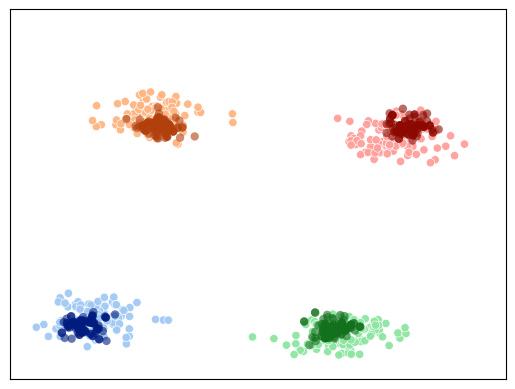

Testing Task1 Matrix on Task2 Data
Cl Loss: 0.020926518365740776 ActLoss: 0.11153164505958557 Actn: 0.9624999761581421 EMD: 16.72460174560547 RowEMD: 0.018557656556367874


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


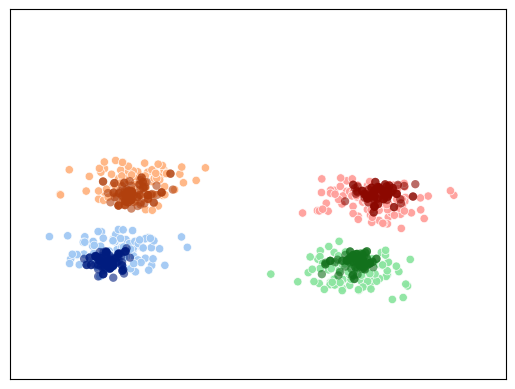

Testing Task2 Matrix on Task2 Data
Cl Loss: 0.006609601899981499 ActLoss: 0.07272645831108093 Actn: 0.9925000071525574 EMD: 16.72998809814453 RowEMD: 0.008224351331591606


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


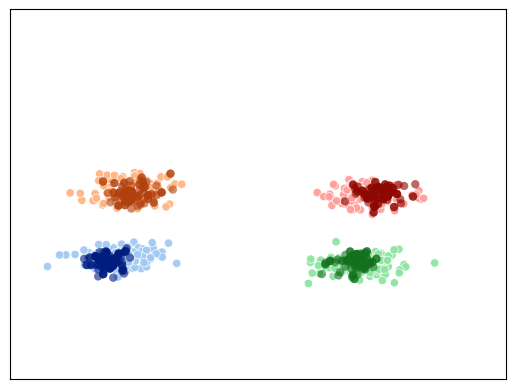

Testing Task2 Matrix on Task1 Data
Cl Loss: 0.020157024264335632 ActLoss: 0.37043526768684387 Actn: 0.8550000190734863 EMD: 20.374330520629883 RowEMD: 0.04669877886772156


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


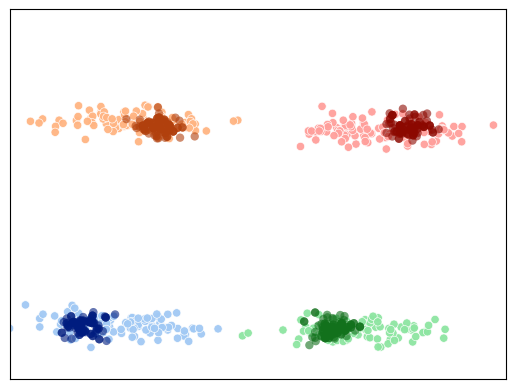

----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


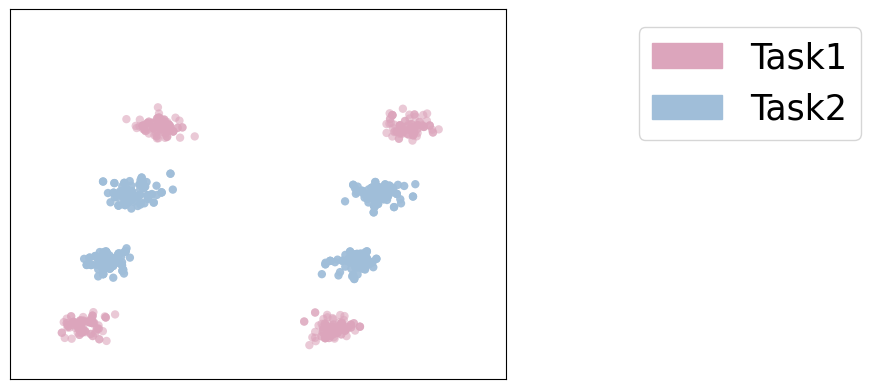

Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.8103886842727661 ActLoss: 2.348454475402832 Actn: 0.47999998927116394 EMD: 20.323814392089844 RowEMD 0.018334170803427696


/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


200 Cl Loss: 0.48316219449043274 ActLoss: 0.13018983602523804 Actn: 0.98499995470047 EMD: 20.628564834594727 RowEMD 0.05012265592813492
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 3000

200 Cl Loss: 0.46821779012680054 ActLoss: 0.13522769510746002 Actn: 0.98499995470047 EMD: 20.62595558166504 RowEMD: 0.048976000398397446
End Task1 Training

Training Task2 Matrix
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.9338645935058594 ActLoss: 2.9209976196289062 Actn: 0.5049999952316284 EMD: 16.780534744262695 RowEMD 0.0064283711835742
200 Cl Loss: 0.509455680847168 ActLoss: 0.045107387006282806 Actn: 0.9925000071525574 EMD: 16.860836029052734 RowEMD 0.011995652690529823
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
method mean
mtx_type 

/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


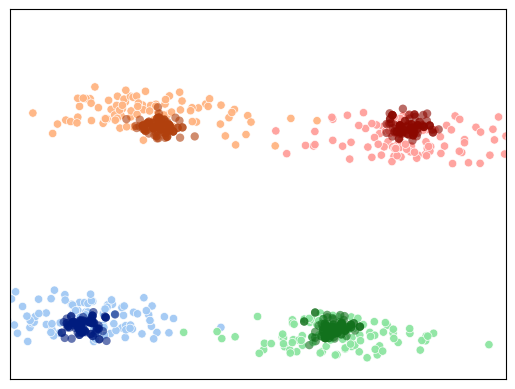

Testing Task1 Matrix on Task2 Data
Cl Loss: 0.30360907316207886 ActLoss: 0.3113144636154175 Actn: 0.8700000047683716 EMD: 16.674365997314453 RowEMD: 0.053690169006586075


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


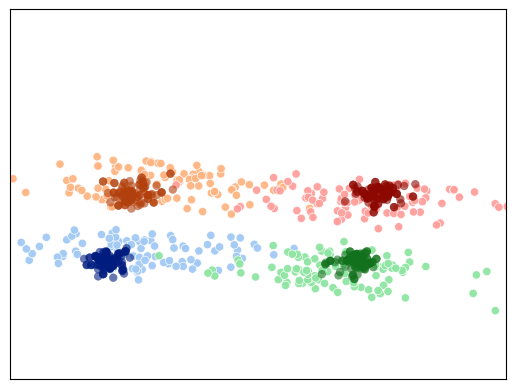

Testing Task2 Matrix on Task2 Data
Cl Loss: 0.24064460396766663 ActLoss: 0.05299939215183258 Actn: 0.9925000071525574 EMD: 16.858043670654297 RowEMD: 0.01600848138332367


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


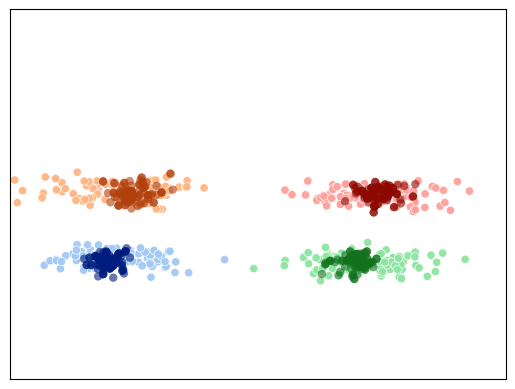

Testing Task2 Matrix on Task1 Data
Cl Loss: 0.2526693642139435 ActLoss: 0.5203744769096375 Actn: 0.8025000095367432 EMD: 20.387466430664062 RowEMD: 0.07273469865322113


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


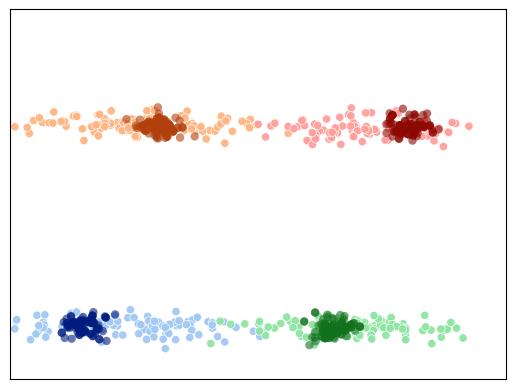

----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


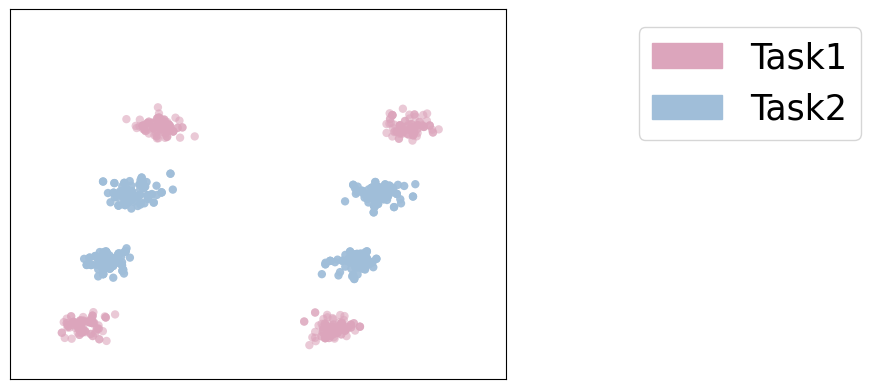

Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.8103886842727661 ActLoss: 2.348454475402832 Actn: 0.47999998927116394 EMD: 20.323814392089844 RowEMD 0.018334170803427696


/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


200 Cl Loss: 0.00048628199147060513 ActLoss: 0.16096344590187073 Actn: 0.9699999690055847 EMD: 20.531558990478516 RowEMD 0.029015755280852318
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 3000

200 Cl Loss: 0.0006190112908370793 ActLoss: 0.15001118183135986 Actn: 0.98499995470047 EMD: 20.56845474243164 RowEMD: 0.03961913287639618
End Task1 Training

Training Task2 Matrix
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.9338645935058594 ActLoss: 2.9209976196289062 Actn: 0.5049999952316284 EMD: 16.780534744262695 RowEMD 0.0064283711835742
200 Cl Loss: 0.24517762660980225 ActLoss: 0.04944298788905144 Actn: 0.9925000071525574 EMD: 16.785131454467773 RowEMD 0.00642610527575016
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_

/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


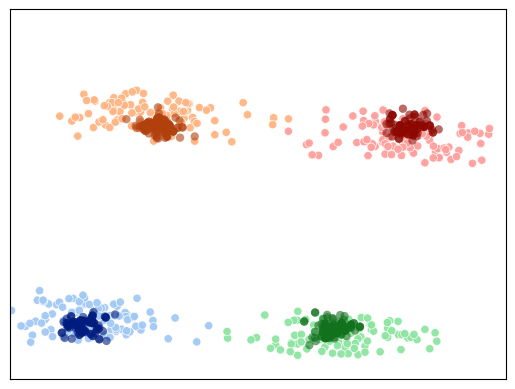

Testing Task1 Matrix on Task2 Data
Cl Loss: 0.039649270474910736 ActLoss: 0.20631039142608643 Actn: 0.9150000214576721 EMD: 16.664337158203125 RowEMD: 0.045016493648290634


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


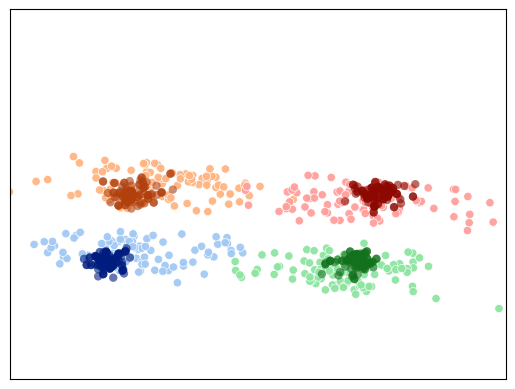

Testing Task2 Matrix on Task2 Data
Cl Loss: 0.05578971281647682 ActLoss: 0.06658817827701569 Actn: 0.987500011920929 EMD: 16.75388526916504 RowEMD: 0.011064089834690094


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


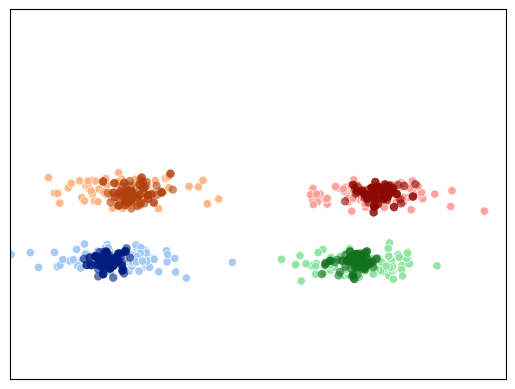

Testing Task2 Matrix on Task1 Data
Cl Loss: 0.06339268386363983 ActLoss: 0.4350156784057617 Actn: 0.8324999809265137 EMD: 20.381074905395508 RowEMD: 0.06544201076030731


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


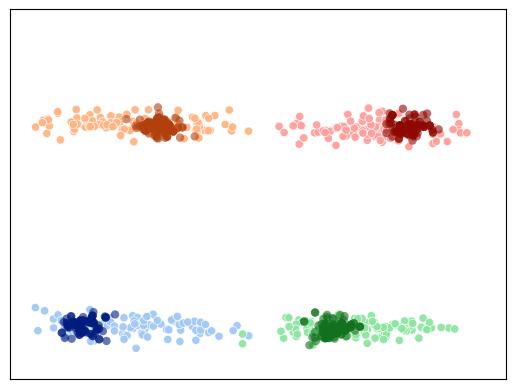

----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


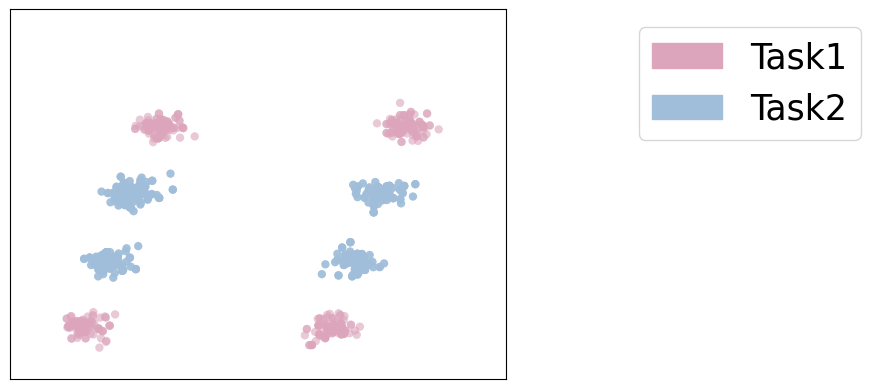

/tmp/ipykernel_1348040/3855041251.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 470/1000 [00:01<00:01, 442.40it/s]


Converged at epoch 470
470 TrnLoss: 0.020444614812731743 ValLoss: 0.04768061265349388 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 480/1000 [00:01<00:01, 463.28it/s]
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 480
480 TrnLoss: 0.011268424801528454 ValLoss: 0.037598416209220886 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: False
CL Loss: False
Training Rotation
0 Cl Loss: 0.8856073617935181 ActLoss: 2.8962929248809814 Actn: 0.48499998450279236 EMD: 20.703105926513672 RowEMD 0.02861020341515541
200 Cl Loss: 0.0002061850536847487 ActLoss: 0.08938504010438919 Actn: 0.9899999499320984 EMD: 20.63995933532715 RowEMD 0.03291347622871399
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 3000

200 Cl Loss: 0.00021538935834541917 ActLoss: 0.08693762868642807 Actn: 0.9925000071525574 EMD: 20.642837524414062 RowEMD: 0.03331976756453514
End Task1 Training

Training Task2 

/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


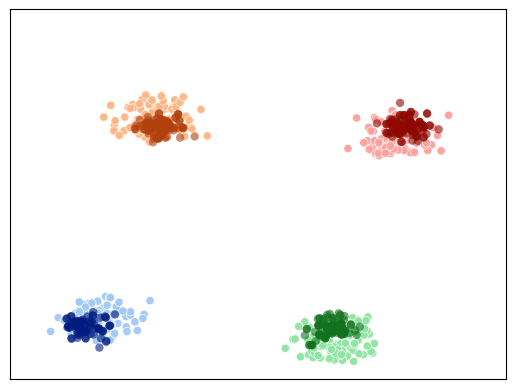

Testing Task1 Matrix on Task2 Data
Cl Loss: 0.022422360256314278 ActLoss: 0.09052333235740662 Actn: 0.9775000214576721 EMD: 18.03823471069336 RowEMD: 0.013269685208797455


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


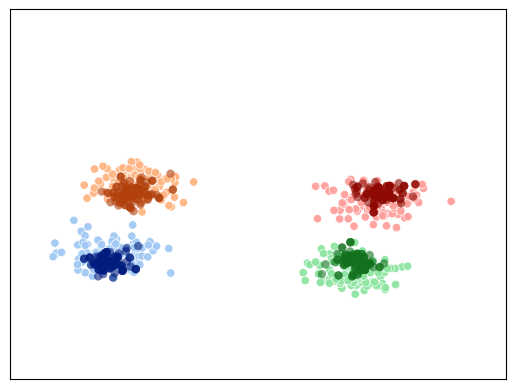

Testing Task2 Matrix on Task2 Data
Cl Loss: 0.007449244149029255 ActLoss: 0.0549437440931797 Actn: 1.0 EMD: 17.99845314025879 RowEMD: 0.007435642182826996


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


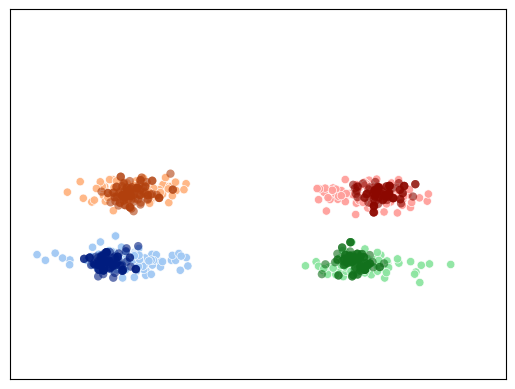

Testing Task2 Matrix on Task1 Data
Cl Loss: 0.018277674913406372 ActLoss: 0.16583913564682007 Actn: 0.9399999976158142 EMD: 20.698074340820312 RowEMD: 0.06539615243673325


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


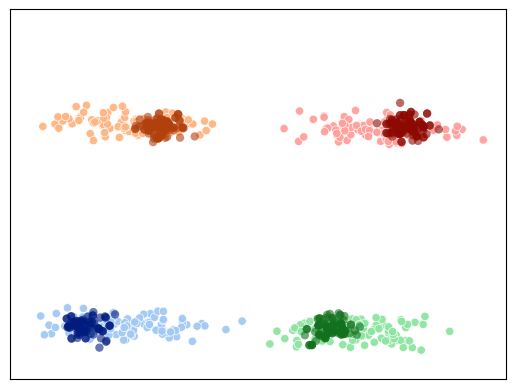

----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


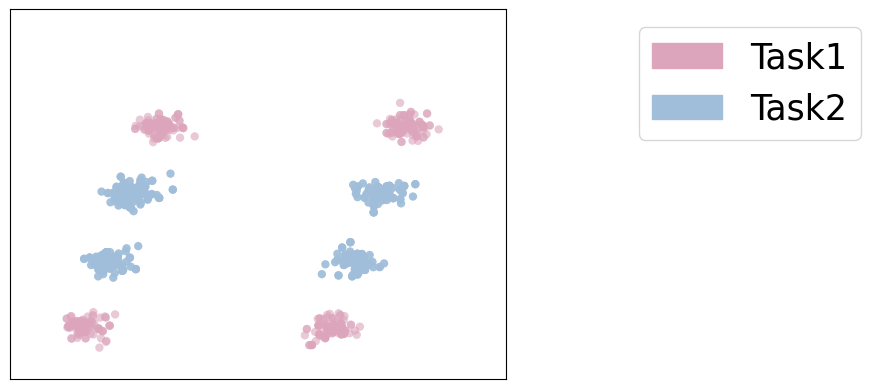

Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.8906435966491699 ActLoss: 2.8826348781585693 Actn: 0.48749998211860657 EMD: 20.61419105529785 RowEMD 0.01833212934434414


/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


200 Cl Loss: 0.4623326063156128 ActLoss: 0.053473953157663345 Actn: 0.9925000071525574 EMD: 20.73442840576172 RowEMD 0.04735293239355087
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 3000

200 Cl Loss: 0.48255452513694763 ActLoss: 0.06508893519639969 Actn: 0.9950000047683716 EMD: 20.73693084716797 RowEMD: 0.048686686903238297
End Task1 Training

Training Task2 Matrix
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.9299342036247253 ActLoss: 2.6426444053649902 Actn: 0.48749998211860657 EMD: 18.0633544921875 RowEMD 0.01918427087366581
200 Cl Loss: 0.5102090239524841 ActLoss: 0.033619605004787445 Actn: 1.0 EMD: 18.12487030029297 RowEMD 0.008867677301168442
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epo

/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


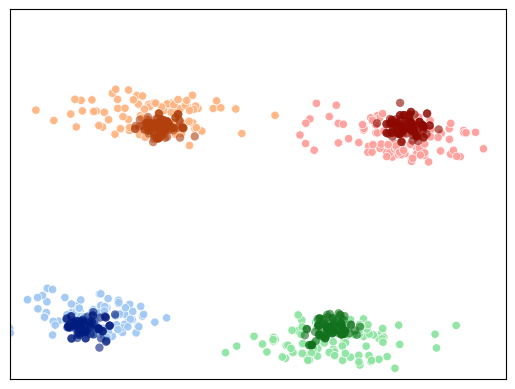

Testing Task1 Matrix on Task2 Data
Cl Loss: 0.23214279115200043 ActLoss: 0.15017439424991608 Actn: 0.9424999952316284 EMD: 18.029117584228516 RowEMD: 0.03332120552659035


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


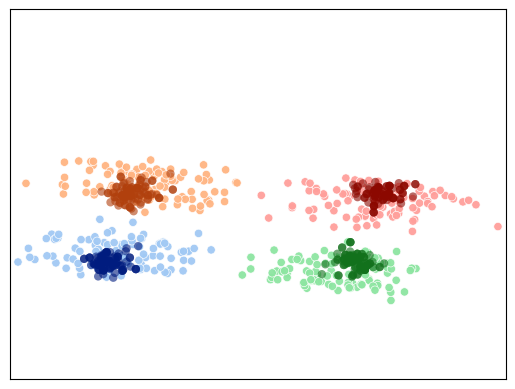

Testing Task2 Matrix on Task2 Data
Cl Loss: 0.27011844515800476 ActLoss: 0.04455123096704483 Actn: 1.0 EMD: 18.10520362854004 RowEMD: 0.016529139131307602


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


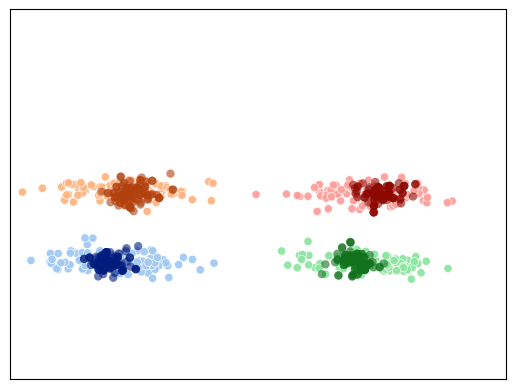

Testing Task2 Matrix on Task1 Data
Cl Loss: 0.2677335739135742 ActLoss: 0.2613006830215454 Actn: 0.8974999785423279 EMD: 20.707561492919922 RowEMD: 0.07704011350870132


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


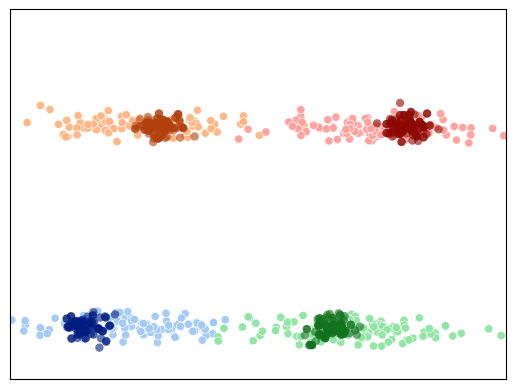

----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


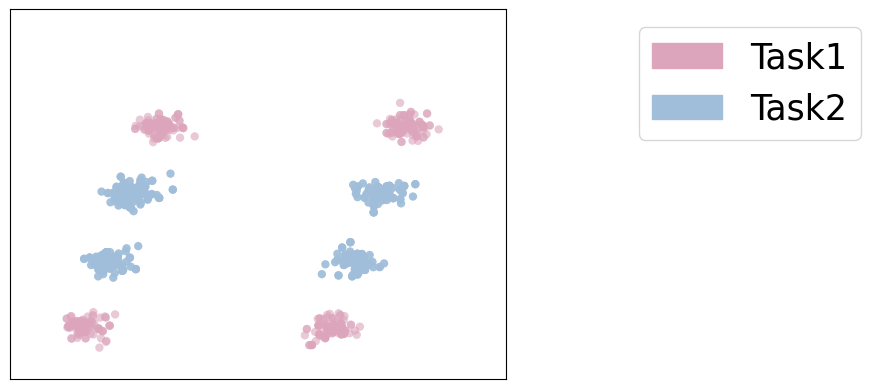

Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.8906435966491699 ActLoss: 2.8826348781585693 Actn: 0.48749998211860657 EMD: 20.61419105529785 RowEMD 0.01833212934434414


/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


200 Cl Loss: 0.0002710951375775039 ActLoss: 0.05911001190543175 Actn: 0.9925000071525574 EMD: 20.686384201049805 RowEMD 0.03760432451963425
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_type orthog
n_epochs 3000

200 Cl Loss: 0.0005640331073664129 ActLoss: 0.06986621767282486 Actn: 0.9950000047683716 EMD: 20.676677703857422 RowEMD: 0.038109149783849716
End Task1 Training

Training Task2 Matrix
Actn Loss: True
CL Loss: True
Training Rotation
0 Cl Loss: 0.9299342036247253 ActLoss: 2.6426444053649902 Actn: 0.48749998211860657 EMD: 18.0633544921875 RowEMD 0.01918427087366581
200 Cl Loss: 0.23013266921043396 ActLoss: 0.036372020840644836 Actn: 1.0 EMD: 18.056894302368164 RowEMD 0.005412876605987549
Converged at epoch 200
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
method mean
mtx_type orthog

/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


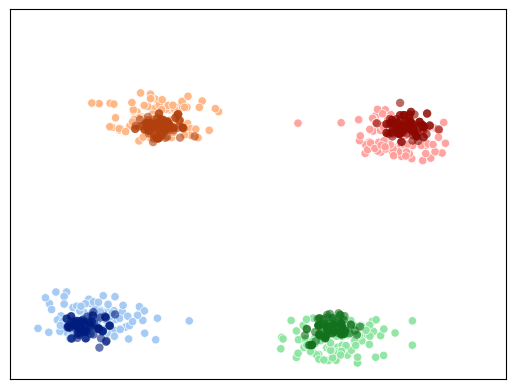

Testing Task1 Matrix on Task2 Data
Cl Loss: 0.04215305298566818 ActLoss: 0.10039392113685608 Actn: 0.9700000286102295 EMD: 18.044147491455078 RowEMD: 0.01648048870265484


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


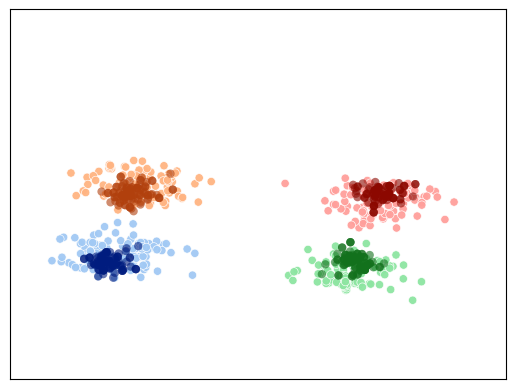

Testing Task2 Matrix on Task2 Data
Cl Loss: 0.05189359560608864 ActLoss: 0.052536386996507645 Actn: 0.9975000023841858 EMD: 17.9893856048584 RowEMD: 0.010785470716655254


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


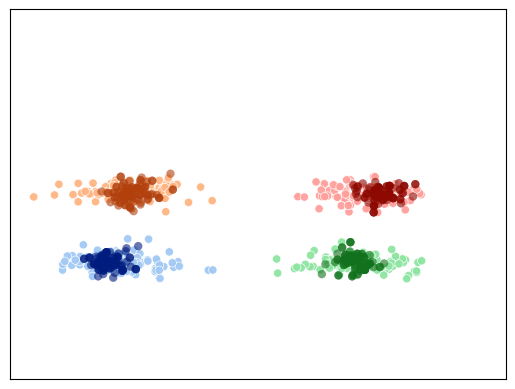

Testing Task2 Matrix on Task1 Data
Cl Loss: 0.05133803188800812 ActLoss: 0.2024839222431183 Actn: 0.9225000143051147 EMD: 20.692195892333984 RowEMD: 0.07858583331108093


/tmp/ipykernel_1348040/3865564183.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)
/tmp/ipykernel_1348040/1085923005.py:52: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1348040/1085923005.py:73: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


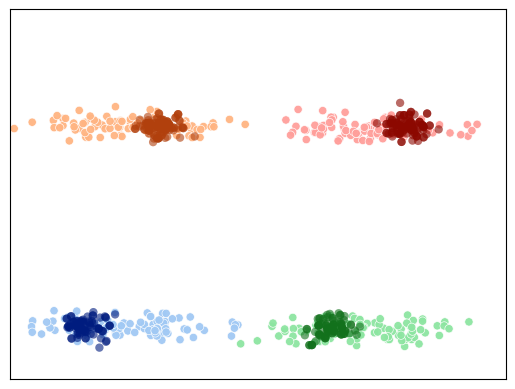

----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
inner_square


/tmp/ipykernel_1348040/2731878652.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_1348040/2731878652.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


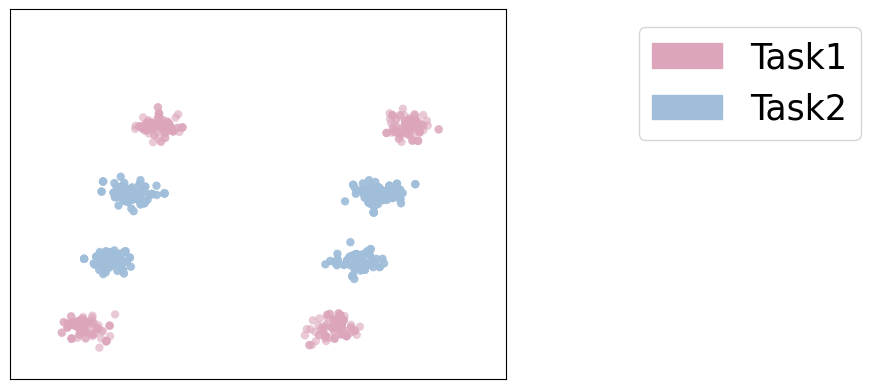

/tmp/ipykernel_1348040/3855041251.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 200, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 473/1000 [00:01<00:01, 470.63it/s]


Converged at epoch 473
473 TrnLoss: 0.015092242509126663 ValLoss: 0.09892348945140839 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 48%|███████████████████████████████████████████████████████████████████▍                                                                         | 478/1000 [00:00<00:01, 484.56it/s]
/tmp/ipykernel_1348040/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 478
478 TrnLoss: 0.011476056650280952 ValLoss: 0.04971085861325264 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_1d True
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1
seed 1

Training Task1 Matrix orthog
Actn Loss: False
CL Loss: False
Training Rotation
0 Cl Loss: 0.919274091720581 ActLoss: 2.5747671127319336 Actn: 0.4899999797344208 EMD: 20.364418029785156 RowEMD 0.014047447592020035


In [ ]:
csv_id = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(csv_id)

data_params = {
    "extra_dims": 64,
    "dupl_rank": 0, # duplicates extra dims
    "zero_rank": 0, # zeros out extra dims in a rotated space
    "cov_strength": 0, # how much do the extraneous dimensions covary with the x and y values,
    "n_samples_per_class": 100,
    "mask_dims": 1,
}

mlp_params = {
    "lr": 0.01,
    "patience": 200,
    "l2": 0.005,
    "bsize": 200,
    "n_epochs": 1000,
    "drop_p": 0.5,
    "hidden_dim": 128,
    "n_layers": 2, # 1-3 layers
    "pre_batchnorm": True,
    "batchnorm": True,
    "ret_best": True,
    "epoch_prog": True,
}


mtx_types = ["orthog",] # "linear"]
n_repeats = 5
do_normalize = False
use_best = "by_acc"
actn_losses = [False, True]

ylim = [-2.75, 2.75]

exp_params = {
    "n_epochs": 3000,
    "lr": 0.05,
    "cl_eps": 100,
    "shuffle_empty": False,
    "method": "mean",
    "incl_extra": False,
    "calc_loss_in_aligned_basis": False,
    "detach_cl_vecs": True,
    "cl_1d": True,
    "mtx_type": "orthog",
    "cl_loss_type": "both",
    "early_stop_patience": 200,
    "rot_dtype": "float", # double or float
}
excl_divisions = {
    "random",
    "random_overlap",
}

dfs = []
all_keys = {*set(data_params.keys()), *set(mlp_params.keys()), *set(exp_params.keys())}
save_keys = ["seed", "incl_extra", "extra_dims", "lr", "incl_actn_loss", "incl_cl_loss", "cl_eps", "mask_dims", "cl_1d"]
excl_keys = [key for key in all_keys if key not in save_keys]
classifier_dict = dict() # used to store trained classifiers
for repeat in range(n_repeats):
    seed = int(str(repeat+1)*5)
    for ial,incl_actn_loss in enumerate(actn_losses):
        for icl,incl_cl_loss in enumerate([False, True,]):
            if not incl_actn_loss and not incl_cl_loss: continue
            d = data_params["extra_dims"]+2
            df_dict = {
                "run_id": [],
                "seed": [],
                "task_num": [],
                "task_division": [],
                "n_samples": [],
                "min_class_count": [],
                "max_class_count": [],
                "mean_class_count": [],
                "class_trn_acc": [],
                "class_val_acc": [],
                "cl_loss": [],
                "actn_loss": [],
                "actn_acc": [],
                "emd": [],
                "row_emd": [],
                "cross_cl_loss": [],
                "cross_actn_loss": [],
                "cross_actn_acc": [],
                "cross_emd": [],
                "cross_row_emd": [],
                "mtx_type": [],
            }
            
            exp_params["incl_cl_loss"] = incl_cl_loss
            exp_params["incl_actn_loss"] = incl_actn_loss
            
            for tdi,task_division in enumerate(divisions):
                if task_division in excl_divisions:
                    print("Skipping", task_division)
                    continue
                print("Starting Task Division", task_division)
                
                np.random.seed(seed)
                torch.manual_seed(seed)

                for _ in mtx_types:
                    df_dict["task_division"].append(task_division)
                    df_dict["task_division"].append(task_division)
                    df_dict["task_num"].append(0)
                    df_dict["task_num"].append(1)
                task1_bools, task2_bools = make_tasks(task_division=task_division, varbs=og_varbs)
            
                ##########################################################################
                ### DATA PREP
                ##########################################################################
                data_dict = prep_data(
                    og_varbs=og_varbs[task1_bools],
                    samples=samples[task1_bools],
                    **data_params,
                )
            
                valids = data_dict["valid_intrvs"]
                if valids.sum() == 0:
                    print("No valid intrvs")
                    continue
                src = data_dict["src_vecs"][valids]
                trg = data_dict["trg_vecs"][valids]
                if do_normalize:
                    src = normalize_fn(src)
                    trg = normalize_fn(trg)
                task1_data = {
                    "src_vecs": src,
                    "trg_vecs": trg,
                    "intrv_varbs": data_dict["intrv_varbs"][valids],
                    "intrv_classes": data_dict["intrv_classes"][valids],
                    "src_varbs": data_dict["src_varbs"][valids],
                    "src_classes": data_dict["src_classes"][valids],
                }
                counts = []
                intrv_classes = data_dict["intrv_classes"]
                for c in sorted(set(intrv_classes.cpu().tolist())):
                    counts.append((intrv_classes==c).long().sum().item())
                for _ in mtx_types:
                    df_dict["n_samples"].append(len(intrv_classes))
                    df_dict["min_class_count"].append(np.min(counts))
                    df_dict["max_class_count"].append(np.max(counts))
                    df_dict["mean_class_count"].append(np.mean(counts))
                print("Class Distr 1:",
                      "\n\tMin:", df_dict["min_class_count"][-1],
                      "\n\tMax:", df_dict["max_class_count"][-1],
                      "\n\tMean:", df_dict["mean_class_count"][-1],
                    )
            
                data_dict = prep_data(
                    og_varbs=og_varbs[task2_bools],
                    samples=samples[task2_bools],
                    **data_params,
                )
            
                valids = data_dict["valid_intrvs"]
                src = data_dict["src_vecs"][valids]
                trg = data_dict["trg_vecs"][valids]
                if do_normalize:
                    src = normalize_fn(src)
                    trg = normalize_fn(trg)
                task2_data = {
                    "src_vecs": src,
                    "trg_vecs": trg,
                    "intrv_varbs": data_dict["intrv_varbs"][valids],
                    "intrv_classes": data_dict["intrv_classes"][valids],
                    "src_varbs": data_dict["src_varbs"][valids],
                    "src_classes": data_dict["src_classes"][valids],
                }
                counts = []
                intrv_classes = data_dict["intrv_classes"]
                for c in sorted(set(intrv_classes.cpu().tolist())):
                    counts.append((intrv_classes==c).long().sum().item())
                for _ in mtx_types:
                    df_dict["n_samples"].append(len(intrv_classes))
                    df_dict["min_class_count"].append(np.min(counts))
                    df_dict["max_class_count"].append(np.max(counts))
                    df_dict["mean_class_count"].append(np.mean(counts))
                print("Class Distr 2:",
                      "\n\tMin:", df_dict["min_class_count"][-1],
                      "\n\tMax:", df_dict["max_class_count"][-1],
                      "\n\tMean:", df_dict["mean_class_count"][-1],
                    )
            
                print(task_division)
                quick_plot(
                    task1_data["src_vecs"], task2_data["src_vecs"],
                    incl_legend=True,
                    labels=["Task1", "Task2"],
                    incl_dividers=False,
                    ylim=ylim,
                )
            
                ##########################################################################
                data_id = "_".join([f"{k}{v}" for k,v in data_params.items()])
                mlp_id = "_".join([f"{k}{v}" for k,v in mlp_params.items()])
                ##########################################################################
                ### Classifier Training
                ##########################################################################
                print("Training Classifier1")
                print("Task Data:", len(task1_data["src_vecs"]))
                print("\t", len(task1_data["src_classes"]))
                print("mlp_params:", mlp_params)
                train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}1"
                if train_id in classifier_dict:
                    classifier1, trn_acc, val_acc = classifier_dict[train_id]
                else:
                    classifier1, trn_acc, val_acc = train_classifier(
                        task1_data["src_vecs"],
                        task1_data["src_classes"],
                        **mlp_params,
                        verbose=False,
                    )
                    classifier_dict[train_id] = (classifier1, trn_acc, val_acc)
                classifier1.cuda()
                classifier1.eval()
                for p in classifier1.parameters():
                    p.requires_grad = False
                for _ in mtx_types:
                    df_dict["class_trn_acc"].append(trn_acc)
                    df_dict["class_val_acc"].append(val_acc)
                
                print("Training Classifier2")
                train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}2"
                if train_id in classifier_dict:
                    classifier2, trn_acc, val_acc = classifier_dict[train_id]
                else:
                    classifier2, trn_acc, val_acc = train_classifier(
                        task2_data["src_vecs"],
                        task2_data["src_classes"],
                        **mlp_params,
                        verbose=False,
                    )
                    classifier_dict[train_id] = (classifier2, trn_acc, val_acc)
                classifier2.cuda()
                classifier2.eval()
                for p in classifier2.parameters():
                    p.requires_grad = False
                for _ in mtx_types:
                    df_dict["class_trn_acc"].append(trn_acc)
                    df_dict["class_val_acc"].append(val_acc)
                
                mask = data_dict["mask"]
            
                ##########################################################################
                ### Rotation Matrix Training
                ##########################################################################
                for mtx_type in mtx_types:
                    print("--------------------")
                    print("Performing New Training")
                    for k in sorted(save_keys):
                        if k in exp_params: v = exp_params[k]
                        elif k in data_params: v = data_params[k]
                        elif k in mlp_params: v = mlp_params[k]
                        print(k,v)
                    print()
                    
                    important_keys = ["cl_loss", "actn_loss", "acc", "emd", "row_emd"]
                        
                    exp_params["mtx_type"] = mtx_type
                    run_id = time.time()
                    df_dict["run_id"].append(run_id)
                    df_dict["run_id"].append(run_id)
                    df_dict["seed"].append(seed)
                    df_dict["seed"].append(seed)
                    df_dict["mtx_type"].append(mtx_type)
                    df_dict["mtx_type"].append(mtx_type)
                    print("Training Task1 Matrix", mtx_type)
                    ret_dict1 = train_rotation(
                        **task1_data,
                        classifier=classifier1,
                        mask=mask,
                        **exp_params,
                        print_every=200,
                        fig_every=np.inf,
                        early_stopping=True,
                    )
                    rd = ret_dict1
                    best_dict = rd["best_metrics"]
                    rm = rd["last_mtx"]
                    if use_best=="by_acc":
                        rm = best_dict["mtx"]
                    elif use_best=="by_loss":
                        rm = rd["bestloss_metrics"]["mtx"]
                        best_dict = rd["bestloss_metrics"]
                    elif use_best=="by_emd":
                        rm = rd["bestemd_metrics"]["mtx"]
                        best_dict = rd["bestemd_metrics"]
                    task1_rot_mtx = rm
                    cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                    print("End Task1 Training")
                    print()
                    df_dict["cl_loss"].append(float(cl_loss))
                    df_dict["actn_loss"].append(float(actn_loss))
                    df_dict["actn_acc"].append(float(acc))
                    df_dict["emd"].append(float(emd))
                    df_dict["row_emd"].append(float(row_emd))
                    
                
                    print("Training Task2 Matrix")
                    ret_dict2 = train_rotation(
                        **task2_data,
                        classifier=classifier2,
                        mask=mask,
                        **exp_params,
                        print_every=200,
                        fig_every=np.inf,
                        early_stopping=True,
                    )
                    rd = ret_dict2
                    best_dict = rd["best_metrics"]
                    rm = rd["last_mtx"]
                    if use_best=="by_acc":
                        rm = best_dict["mtx"]
                    elif use_best=="by_loss":
                        rm = rd["bestloss_metrics"]["mtx"]
                        best_dict = rd["bestloss_metrics"]
                    elif use_best=="by_emd":
                        rm = rd["bestemd_metrics"]["mtx"]
                        best_dict = rd["bestemd_metrics"]
                    task2_rot_mtx = rm
                    cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                    print("End Task2 Training")
                    print()
                    df_dict["cl_loss"].append(float(cl_loss))
                    df_dict["actn_loss"].append(float(actn_loss))
                    df_dict["actn_acc"].append(float(acc))
                    df_dict["emd"].append(float(emd))
                    df_dict["row_emd"].append(float(row_emd))
                
                
                    ##########################################################################
                    ### Testing
                    ##########################################################################
                    save_params = {**data_params, **exp_params}
                    for k in list(save_params.keys()):
                        if k in excl_keys: del save_params[k]
                    save_params["task"] = 1
                    save_name = os.path.join("figs/",get_plot_save_name(save_params))
                    print("Testing Task1 Matrix on Task1 Data")
                    cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                        task1_rot_mtx,
                        task1_data,
                        classifier=classifier1,
                        mask=mask,
                        **exp_params,
                        ylim=ylim,
                        fig_save_name=save_name,
                    )
                    print("Testing Task1 Matrix on Task2 Data")
                    cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                        task1_rot_mtx,
                        task2_data,
                        classifier=classifier2,
                        mask=mask,
                        **exp_params,
                        ylim=ylim,
                        fig_save_name=save_name,
                    )
                    df_dict["cross_cl_loss"].append(float(cl_loss))
                    df_dict["cross_actn_loss"].append(float(actn_loss))
                    df_dict["cross_actn_acc"].append(float(acc))
                    df_dict["cross_emd"].append(float(emd))
                    df_dict["cross_row_emd"].append(float(row_emd))
                    
                    print("Testing Task2 Matrix on Task2 Data")
                    cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                        task2_rot_mtx,
                        task2_data,
                        classifier=classifier2,
                        mask=mask,
                        **exp_params,
                        ylim=ylim,
                        fig_save_name=save_name,
                    )
                    print("Testing Task2 Matrix on Task1 Data")
                    save_params["task"] = 2
                    save_name = os.path.join("figs/",get_plot_save_name(save_params))
                    cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                        task2_rot_mtx,
                        task1_data,
                        classifier=classifier1,
                        mask=mask,
                        **exp_params,
                        ylim=ylim,
                        fig_save_name=save_name,
                    )
                    df_dict["cross_cl_loss"].append(float(cl_loss))
                    df_dict["cross_actn_loss"].append(float(actn_loss))
                    df_dict["cross_actn_acc"].append(float(acc))
                    df_dict["cross_emd"].append(float(emd))
                    df_dict["cross_row_emd"].append(float(row_emd))
                    
                    classifier1.cpu()
                    classifier2.cpu()
                    print("-"*100)
                    print()
                    print()
                    print()
                    print()
                    print()
            df = pd.DataFrame(df_dict)
            for k in exp_params:
                if k!="mtx_type":
                    df[k] = exp_params[k]
            for k in data_params:
                df[k] = data_params[k]
            dfs.append(df)
        full_df = pd.concat(dfs)
        full_df.to_csv(f"csvs/task_ablations_{csv_id}.csv", header=True, index=False)

In [ ]:
if csv_id is None:
    csv_ids = []
    for f in os.listdir("csvs"):
        if "task_ablations_" in f:
            csv_ids.append(f.split("task_ablations_")[-1].split(".")[0])
    csv_ids = sorted(csv_ids)
    print("Need to pick csv id:")
    for i,csv in enumerate(csv_ids):
        print(i, csv)
else:
    full_df = pd.read_csv(f"csvs/task_ablations_{csv_id}.csv")
    full_df


In [ ]:
from datetime import datetime
now = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(now)

In [ ]:
full_df.loc[full_df["class_val_acc"]<0.95] # look at cases where the classifier was bad

In [ ]:
CL = "CL"
CLDAS = "CL+\nDAS"
DAS = "DAS"
loss_map = {
    (False,True): CL,
    (True,True): CLDAS,
    (True,False): DAS,
}
full_df["loss_type"] = full_df.apply(lambda x: loss_map[(x.incl_actn_loss, x.incl_cl_loss)], axis=1)

In [ ]:
color_order = [
    #-3,0,4,4,6,3,2,0,6,7,-1
    2,-1,-3,4,4,6,3,2,0,6,7,-1
]

In [ ]:
full_df["extra_dims"].unique()

In [ ]:
# Pick cases you want to plot
incl_filters = {
    #"mtx_type": ["orthog"],
    "extra_dims": [64], # 16,],
    "incl_extra": [False],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    "mask_dims": [1,],
    #"lr": [0.05],
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    #"task_division": ["inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0.95

rot = 35
ylim = [0.58,1.02]
x = "cl_eps"
y = "cross_actn_acc"
hue = "task_num"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
p = [sns.color_palette("pastel")[i] for i in color_order]
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 25
legendsize = 20
linewidth = 4
err_alpha = 0.3
yticks = [0.6, 0.8, 1.0]


sort_map = {0:0,1:1}
for task in set(full_df["task_division"]):
    print("Starting Task", task)
    plot_df = full_df.loc[full_df["mtx_type"]==mtx_type].copy()
    plot_df = plot_df.loc[plot_df["class_val_acc"]>class_acc_threshold]
    for filt,vals in incl_filters.items():
        plot_df = plot_df.loc[plot_df[filt].isin(vals)]
    for filt,vals in excl_filters.items():
        plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
    plot_df = plot_df.loc[plot_df["task_division"]==task]
    plot_df = plot_df.copy()
    if len(plot_df)<=0:
        print("No samples for task", task)
        continue
    
    #combo_df = plot_df.loc[plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]].copy()
    #combo_df["cl_eps"] = 0
    #combo_df["incl_cl_loss"] = True
    #cl_df = combo_df.copy()
    #cl_df["incl_actn_loss"] = False
    #plot_df = pd.concat([ plot_df, combo_df, cl_df, ])
    
    bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
    plot_df.loc[bools,"cl_eps"] = 0
    bloss_acc = dict(plot_df.loc[bools].groupby(hue)[y].mean())
    bloss_err = dict(plot_df.loc[bools].groupby(hue)[y].sem())
    bloss_emd = dict(plot_df.loc[bools].groupby(hue)["cross_row_emd"].mean())
    bloss_emr = dict(plot_df.loc[bools].groupby(hue)["cross_row_emd"].sem())
    print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)
    print("Behavior Only EMD", bloss_emd, "+/-", bloss_emr)
    
    fig,axes = plt.subplots(1,3,figsize=(15,5))
    
    print(task)
    ax = axes[0]
    plt.sca(ax)
    temp_df = plot_df.loc[plot_df["loss_type"].isin({CL,DAS})]
    sns.barplot(x=x, y=y, hue=hue, data=temp_df, ax=ax, palette=p, errorbar="se")
    plt.title(f"CL Only", fontsize=titlesize)
    plt.ylim(ylim)
    plt.xlabel("Loss Type", fontsize=labelsize)
    plt.ylabel("Cross Task IIA", fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(yticks,fontsize=ticksize)
    
    # Baseline
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    pp = [sns.color_palette("dark")[i] for i in color_order]
    for i,k in enumerate(bloss_acc):
        acc = bloss_acc[k]
        err = bloss_err[k]
        color = pp[sort_map[k]]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
        
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize)
    
    # CL + DAS
    ax = axes[1]
    plt.sca(ax)
    temp_df = plot_df.loc[plot_df["loss_type"].isin({CLDAS,DAS})]
    sns.barplot(x=x, y=y, hue=hue, data=temp_df, ax=ax, palette=p, errorbar="se")
    plt.title(f"CL + DAS", fontsize=titlesize)
    plt.ylim(ylim)
    plt.xlabel("Loss Type", fontsize=labelsize)
    plt.ylabel("")
    plt.xticks(fontsize=ticksize)
    plt.yticks(yticks,fontsize=ticksize)
    
    # Baseline
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    pp = [sns.color_palette("dark")[i] for i in color_order]
    for i,k in enumerate(bloss_acc):
        acc = bloss_acc[k]
        err = bloss_err[k]
        color = pp[sort_map[k]]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
        
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize)
    
    # EMD
    ax = axes[2]
    plt.sca(ax)
    dupl_cols = [
        "seed", "incl_extra", "extra_dims",
        "lr", "incl_actn_loss", "incl_cl_loss",
        "mask_dims", "cl_1d", "loss_type"
    ] # filter for best cl eps
    temp_df = plot_df.sort_values(by="cross_actn_acc", ascending=False)\
        .drop_duplicates(dupl_cols)
    sns.barplot(x="loss_type", y="cross_row_emd", hue=hue, data=temp_df, ax=ax, palette=p)
    plt.title(f"{task}", fontsize=titlesize)
    plt.xlabel("Loss Type", fontsize=labelsize)
    plt.ylabel("Cross Task EMD", fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize).set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(f"figs/ood_inner_square_{extra_dims}d.png", dpi=600, bbox_inches="tight")
    plt.show()

In [ ]:
incl_filters = {
    #"mtx_type": ["orthog"],
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    "extra_dims": [64], # 16,],
    "mask_dims": [1,],
    #"lr": [0.01],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    "task_division": ["inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

groups = ["loss_type",]
metrics = ["emd", "row_emd", "cross_emd", "cross_row_emd", "actn_acc", "cross_actn_acc",]
mtx_type = "orthog"

plot_df = full_df.loc[full_df["mtx_type"]==mtx_type].copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()

temp = plot_df.groupby(groups)[metrics]\
    .agg(["mean", "sem"]).reset_index()
columns = []
for col in temp.columns:
    if type(col)==tuple:
        columns.append(f"{col[0]} {col[1]}".replace(" mean", "").strip())
    else:
        columns.append(col.strip())
temp.columns = columns
#temp.sort_values(by=["spacing_order", "cl_eps"], ascending=False)
temp.sort_values(by=["loss_type"])

## Hyperparameter Search

In [ ]:
import time
from toytask_utils import all_divisions
from datetime import datetime

csv_id = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(csv_id)


data_params = {
    "extra_dims": 128,
    "dupl_rank": 0, # duplicates extra dims
    "zero_rank": 0, # zeros out extra dims in a rotated space
    "cov_strength": 0, # how much do the extraneous dimensions covary with the x and y values,
    "n_samples_per_class": 100,
    "mask_dims": 1,
}

mlp_params = {
    "lr": 0.01,
    "patience": 200,
    "l2": 0.005,
    "bsize": 200,
    "patience": 100,
    "n_epochs": 1000,
    "drop_p": 0.5,
    "hidden_dim": 128,
    "n_layers": 2, # 1-3 layers
    "pre_batchnorm": True,
    "batchnorm": True,
    "ret_best": True,
    "epoch_prog": True,
}


divisions = [ "inner_square", "original" ]
mtx_types = ["orthog",] # "linear"]
cl_epses = [1, 10, 50, 100]
lrs = [0.05, 0.01, 0.005] #, 0.1, 0.01, 0.005]
extra_dims_list = [0,16,64,128]
incl_extras = [False] # determines if extraneous subspace should be included in cl loss
mask_dims = [1,4,8]
do_normalize = False
use_best = "by_acc"
actn_losses = [False, True]
n_repeats = 5


search_cols = ["task_division", "mtx_type", "cl_eps", "lr", "extra_dims", "incl_extras", "mask_dims", "seed"]

ylim = [-2.75, 1.75]

exp_params = {
    "n_epochs": 3000,
    "lr": 0.01,
    "cl_eps": 100,
    "shuffle_empty": False,
    "method": "mean",
    "incl_extra": False,
    "calc_loss_in_aligned_basis": False,
    "detach_cl_vecs": True,
    "cl_1d": True,
    "mtx_type": "orthog",
    "cl_loss_type": "both",
    "early_stop_patience": 200,
}



dfs = []
all_keys = {*set(data_params.keys()), *set(mlp_params.keys()), *set(exp_params.keys())}
save_keys = ["incl_extra", "extra_dims", "lr", "incl_actn_loss", "incl_cl_loss", "cl_eps", "mask_dims"]
excl_keys = [key for key in all_keys if key not in save_keys]
classifier_dict = dict()
for incl_extra in incl_extras:
    exp_params["incl_extra"] = incl_extra
    for mask_dim in mask_dims:
        for repeat in range(n_repeats):
            seed = int(str(repeat+1)*5)
            for extra_dims in extra_dims_list:
                data_params["extra_dims"] = extra_dims
                for lr in lrs:
                    exp_params["lr"] = lr
                    for ial,incl_actn_loss in enumerate(actn_losses):
                        for icl,incl_cl_loss in enumerate([False, True,]):
                            if not incl_actn_loss and not incl_cl_loss: continue
                            for ice, cl_eps in enumerate(cl_epses):
                                if ice > 0 and not incl_cl_loss: continue
                                d = data_params["extra_dims"]+2
                                if mask_dim*2 > d: continue
                                data_params["mask_dims"] = mask_dim
                                df_dict = {
                                    "run_id": [],
                                    "seed": [],
                                    "task_num": [],
                                    "task_division": [],
                                    "n_samples": [],
                                    "min_class_count": [],
                                    "max_class_count": [],
                                    "mean_class_count": [],
                                    "class_trn_acc": [],
                                    "class_val_acc": [],
                                    "cl_loss": [],
                                    "actn_loss": [],
                                    "actn_acc": [],
                                    "emd": [],
                                    "row_emd": [],
                                    "cross_cl_loss": [],
                                    "cross_actn_loss": [],
                                    "cross_actn_acc": [],
                                    "cross_emd": [],
                                    "cross_row_emd": [],
                                    "mtx_type": [],
                                }

                                exp_params["incl_cl_loss"] = incl_cl_loss
                                exp_params["incl_actn_loss"] = incl_actn_loss

                                for tdi,task_division in enumerate(divisions):
                                    if task_division in excl_divisions:
                                        print("Skipping", task_division)
                                        continue
                                    print("Starting Task Division", task_division)

                                    np.random.seed(seed)
                                    torch.manual_seed(seed)

                                    for _ in mtx_types:
                                        df_dict["task_division"].append(task_division)
                                        df_dict["task_division"].append(task_division)
                                        df_dict["task_num"].append(0)
                                        df_dict["task_num"].append(1)
                                    task1_bools, task2_bools = make_tasks(task_division=task_division, varbs=og_varbs)

                                    ##########################################################################
                                    ### DATA PREP
                                    ##########################################################################
                                    data_dict = prep_data(
                                        og_varbs=og_varbs[task1_bools],
                                        samples=samples[task1_bools],
                                        **data_params,
                                    )

                                    valids = data_dict["valid_intrvs"]
                                    if valids.sum() == 0:
                                        print("No valid intrvs")
                                        continue
                                    src = data_dict["src_vecs"][valids]
                                    trg = data_dict["trg_vecs"][valids]
                                    if do_normalize:
                                        src = normalize_fn(src)
                                        trg = normalize_fn(trg)
                                    task1_data = {
                                        "src_vecs": src,
                                        "trg_vecs": trg,
                                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                                        "intrv_classes": data_dict["intrv_classes"][valids],
                                        "src_varbs": data_dict["src_varbs"][valids],
                                        "src_classes": data_dict["src_classes"][valids],
                                    }
                                    counts = []
                                    intrv_classes = data_dict["intrv_classes"]
                                    for c in sorted(set(intrv_classes.cpu().tolist())):
                                        counts.append((intrv_classes==c).long().sum().item())
                                    for _ in mtx_types:
                                        df_dict["n_samples"].append(len(intrv_classes))
                                        df_dict["min_class_count"].append(np.min(counts))
                                        df_dict["max_class_count"].append(np.max(counts))
                                        df_dict["mean_class_count"].append(np.mean(counts))
                                    print("Class Distr 1:",
                                          "\n\tMin:", df_dict["min_class_count"][-1],
                                          "\n\tMax:", df_dict["max_class_count"][-1],
                                          "\n\tMean:", df_dict["mean_class_count"][-1],
                                        )

                                    data_dict = prep_data(
                                        og_varbs=og_varbs[task2_bools],
                                        samples=samples[task2_bools],
                                        **data_params,
                                    )

                                    valids = data_dict["valid_intrvs"]
                                    src = data_dict["src_vecs"][valids]
                                    trg = data_dict["trg_vecs"][valids]
                                    if do_normalize:
                                        src = normalize_fn(src)
                                        trg = normalize_fn(trg)
                                    task2_data = {
                                        "src_vecs": src,
                                        "trg_vecs": trg,
                                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                                        "intrv_classes": data_dict["intrv_classes"][valids],
                                        "src_varbs": data_dict["src_varbs"][valids],
                                        "src_classes": data_dict["src_classes"][valids],
                                    }
                                    counts = []
                                    intrv_classes = data_dict["intrv_classes"]
                                    for c in sorted(set(intrv_classes.cpu().tolist())):
                                        counts.append((intrv_classes==c).long().sum().item())
                                    for _ in mtx_types:
                                        df_dict["n_samples"].append(len(intrv_classes))
                                        df_dict["min_class_count"].append(np.min(counts))
                                        df_dict["max_class_count"].append(np.max(counts))
                                        df_dict["mean_class_count"].append(np.mean(counts))
                                    print("Class Distr 2:",
                                          "\n\tMin:", df_dict["min_class_count"][-1],
                                          "\n\tMax:", df_dict["max_class_count"][-1],
                                          "\n\tMean:", df_dict["mean_class_count"][-1],
                                        )

                                    print(task_division)
                                    quick_plot(
                                        task1_data["src_vecs"], task2_data["src_vecs"],
                                        incl_legend=True,
                                        labels=["Task1", "Task2"],
                                        incl_dividers=False,
                                        ylim=ylim,
                                    )

                                    ##########################################################################
                                    data_id = "_".join([f"{k}{v}" for k,v in data_params.items()])
                                    mlp_id = "_".join([f"{k}{v}" for k,v in mlp_params.items()])
                                    ##########################################################################
                                    ### Classifier Training
                                    ##########################################################################
                                    print("Training Classifier1")
                                    print("Task Data:", len(task1_data["src_vecs"]))
                                    print("\t", len(task1_data["src_classes"]))
                                    print("mlp_params:", mlp_params)
                                    train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}1"
                                    if train_id in classifier_dict:
                                        classifier1, trn_acc, val_acc = classifier_dict[train_id]
                                    else:
                                        classifier1, trn_acc, val_acc = train_classifier(
                                            task1_data["src_vecs"],
                                            task1_data["src_classes"],
                                            **mlp_params,
                                            verbose=False,
                                        )
                                        classifier_dict[train_id] = (classifier1, trn_acc, val_acc)
                                    classifier1.cuda()
                                    classifier1.eval()
                                    for p in classifier1.parameters():
                                        p.requires_grad = False
                                    for _ in mtx_types:
                                        df_dict["class_trn_acc"].append(trn_acc)
                                        df_dict["class_val_acc"].append(val_acc)

                                    print("Training Classifier2")
                                    train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}2"
                                    if train_id in classifier_dict:
                                        classifier2, trn_acc, val_acc = classifier_dict[train_id]
                                    else:
                                        classifier2, trn_acc, val_acc = train_classifier(
                                            task2_data["src_vecs"],
                                            task2_data["src_classes"],
                                            **mlp_params,
                                            verbose=False,
                                        )
                                        classifier_dict[train_id] = (classifier2, trn_acc, val_acc)
                                    classifier2.cuda()
                                    classifier2.eval()
                                    for p in classifier2.parameters():
                                        p.requires_grad = False
                                    for _ in mtx_types:
                                        df_dict["class_trn_acc"].append(trn_acc)
                                        df_dict["class_val_acc"].append(val_acc)

                                    mask = data_dict["mask"]

                                    ##########################################################################
                                    ### Rotation Matrix Training
                                    ##########################################################################
                                    for mtx_type in mtx_types:
                                        print("--------------------")
                                        print("Performing New Training")
                                        for k in sorted(save_keys):
                                            if k in exp_params: v = exp_params[k]
                                            elif k in data_params: v = data_params[k]
                                            elif k in mlp_params: v = mlp_params[k]
                                            print(k,v)
                                        print()

                                        important_keys = ["cl_loss", "actn_loss", "acc", "emd", "row_emd"]

                                        exp_params["mtx_type"] = mtx_type
                                        run_id = time.time()
                                        df_dict["run_id"].append(run_id)
                                        df_dict["run_id"].append(run_id)
                                        df_dict["seed"].append(seed)
                                        df_dict["seed"].append(seed)
                                        df_dict["mtx_type"].append(mtx_type)
                                        df_dict["mtx_type"].append(mtx_type)
                                        print("Training Task1 Matrix", mtx_type)
                                        ret_dict1 = train_rotation(
                                            **task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            print_every=200,
                                            fig_every=np.inf,
                                            early_stopping=True,
                                        )
                                        rd = ret_dict1
                                        best_dict = rd["best_metrics"]
                                        rm = rd["last_mtx"]
                                        if use_best=="by_acc":
                                            rm = best_dict["mtx"]
                                        elif use_best=="by_loss":
                                            rm = rd["bestloss_metrics"]["mtx"]
                                            best_dict = rd["bestloss_metrics"]
                                        elif use_best=="by_emd":
                                            rm = rd["bestemd_metrics"]["mtx"]
                                            best_dict = rd["bestemd_metrics"]
                                        task1_rot_mtx = rm
                                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                                        print("End Task1 Training")
                                        print()
                                        df_dict["cl_loss"].append(float(cl_loss))
                                        df_dict["actn_loss"].append(float(actn_loss))
                                        df_dict["actn_acc"].append(float(acc))
                                        df_dict["emd"].append(float(emd))
                                        df_dict["row_emd"].append(float(row_emd))


                                        print("Training Task2 Matrix")
                                        ret_dict2 = train_rotation(
                                            **task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            print_every=200,
                                            fig_every=np.inf,
                                            early_stopping=True,
                                        )
                                        rd = ret_dict2
                                        best_dict = rd["best_metrics"]
                                        rm = rd["last_mtx"]
                                        if use_best=="by_acc":
                                            rm = best_dict["mtx"]
                                        elif use_best=="by_loss":
                                            rm = rd["bestloss_metrics"]["mtx"]
                                            best_dict = rd["bestloss_metrics"]
                                        elif use_best=="by_emd":
                                            rm = rd["bestemd_metrics"]["mtx"]
                                            best_dict = rd["bestemd_metrics"]
                                        task2_rot_mtx = rm
                                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                                        print("End Task2 Training")
                                        print()
                                        df_dict["cl_loss"].append(float(cl_loss))
                                        df_dict["actn_loss"].append(float(actn_loss))
                                        df_dict["actn_acc"].append(float(acc))
                                        df_dict["emd"].append(float(emd))
                                        df_dict["row_emd"].append(float(row_emd))


                                        ##########################################################################
                                        ### Testing
                                        ##########################################################################
                                        save_params = {**data_params, **exp_params}
                                        for k in list(save_params.keys()):
                                            if k in excl_keys: del save_params[k]
                                        save_params["task"] = 1
                                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                                        print("Testing Task1 Matrix on Task1 Data")
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task1_rot_mtx,
                                            task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                        )
                                        print("Testing Task1 Matrix on Task2 Data")
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task1_rot_mtx,
                                            task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                        )
                                        df_dict["cross_cl_loss"].append(float(cl_loss))
                                        df_dict["cross_actn_loss"].append(float(actn_loss))
                                        df_dict["cross_actn_acc"].append(float(acc))
                                        df_dict["cross_emd"].append(float(emd))
                                        df_dict["cross_row_emd"].append(float(row_emd))

                                        print("Testing Task2 Matrix on Task2 Data")
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task2_rot_mtx,
                                            task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                        )
                                        print("Testing Task2 Matrix on Task1 Data")
                                        save_params["task"] = 2
                                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task2_rot_mtx,
                                            task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                        )
                                        df_dict["cross_cl_loss"].append(float(cl_loss))
                                        df_dict["cross_actn_loss"].append(float(actn_loss))
                                        df_dict["cross_actn_acc"].append(float(acc))
                                        df_dict["cross_emd"].append(float(emd))
                                        df_dict["cross_row_emd"].append(float(row_emd))

                                        classifier1.cpu()
                                        classifier2.cpu()
                                        print("-"*100)
                                        print()
                                        print()
                                        print()
                                        print()
                                        print()
                                df = pd.DataFrame(df_dict)
                                for k in exp_params:
                                    if k!="mtx_type":
                                        df[k] = exp_params[k]
                                for k in data_params:
                                    df[k] = data_params[k]
                                dfs.append(df)
                            full_df = pd.concat(dfs)
                            full_df.to_csv(f"csvs/cl_ablations_{csv_id}.csv", header=True, index=False)

In [54]:
if csv_id is None:
    csv_ids = []
    for f in os.listdir("csvs"):
        if "cl_ablations_" in f:
            csv_ids.append(f.split("cl_ablations_")[-1].split(".")[0])
    csv_ids = sorted(csv_ids)
    print("Need to pick csv id:")
    for i,csv in enumerate(csv_ids):
        print(i, csv)
else:
    full_df = pd.read_csv(f"csvs/cl_ablations_{csv_id}.csv")
    full_df

In [55]:
search_cols = ["incl_actn_loss", "incl_cl_loss", "task_division", "mtx_type", "cl_eps", "lr", "extra_dims", "incl_extra", "mask_dims"]
cols = [
    "run_id",
    "task_num", "task_division", "mtx_type", "incl_cl_loss", "incl_actn_loss", "cl_eps",
    "min_class_count", "max_class_count", "mean_class_count",
    "actn_acc", "cross_actn_acc",
    "emd", "cross_emd",
    "row_emd", "cross_row_emd",
]
# exp_keys = list(exp_params.keys())
# df = pd.merge(left=full_df, right=counts_df, on=["task_num", "task_division"]+exp_keys) 
# df.sort_values(by=["task_division", "task_num", "cross_actn_acc"], ascending=False)[cols]

#full_df.sort_values(by=["task_division", "task_num", "cross_actn_acc"], ascending=False)[cols]
metric_cols = [
    "actn_acc", "cross_actn_acc",
    "emd", "cross_emd",
    "row_emd", "cross_row_emd",
]
full_df.groupby(search_cols)[metric_cols].agg("mean")

actn_acc  cross_actn_acc        emd  cross_emd   row_emd  cross_row_emd
incl_actn_loss incl_cl_loss task_division mtx_type cl_eps lr    extra_dims incl_extra mask_dims                                                                         
False          True         inner_square  orthog   100    0.005 0          False      1          0.960250        0.882000   0.094876   0.071295  0.094876       0.071295
                                                                16         False      1          0.997000        0.980750   3.985676   4.013214  0.017101       0.033715
                                                                                      4          0.968250        0.946000   5.154483   5.528760  0.030282       0.054647
                                                                                      8          0.962000        0.955750   6.020472   6.283547  0.032077       0.053242
                                                                64         False      1          0.984250        0.952500  19.198304  19.251049  0.015434       0.037114
                                                                                      4          0.943250        0.854750  20.279165  21.107014  0.060351       0.089520
                                                                                      8          0.930750        0.857750  21.292335  23.542534  0.067353       0.092886
                                                                128        False      1          0.903500        0.840500  40.840189  40.920929  0.041069       0.065856
                                                                                      4          0.878000        0.738750  41.999506  42.768189  0.083121       0.114356
                                                                                      8          0.873000        0.746000  42.952436  45.224819  0.091971       0.124197
                                                          0.010 0          False      1          0.998250        0.927750   0.058288   0.050816  0.058288       0.050816
                                                                16         False      1          0.997000        0.979000   3.986548   4.006041  0.017268       0.031574
                                                                                      4          0.978000        0.962750   5.119467   5.479135  0.026641       0.042681
                                                                                      8          0.963250        0.958500   5.998204   6.296507  0.031250       0.050814
                                                                64         False      1          0.984250        0.955000  19.194882  19.252352  0.016119       0.035843
                                                                                      4          0.947750        0.851750  20.217840  21.111743  0.061520       0.085896
                                                                                      8          0.931500        0.854250  21.111549  23.482870  0.065805       0.100146
                                                                128        False      1          0.938000        0.871500  40.854750  40.915391  0.033006       0.058610
                                                                                      4          0.880750        0.743250  41.917089  42.752451  0.087834       0.105629
                                                                                      8          0.878250        0.751000  42.777492  45.188437  0.087395       0.121594
                                                          0.050 0          False      1          0.998667        0.945167   0.052000   0.053032  0.052000       0.053032
                                                                16         False      1          0.997500        0.980417   3.977665   4.025991  0.018482       0.038163
                                         

In [56]:
from datetime import datetime
now = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(now)
full_df.to_csv(f"csvs/inner_square_ablations_{now}.csv", index=False, header=True)

11-12-2025_12H21M


In [57]:
sort_map = {
    "Original": 0,
    "Dense": 1,
    "Sparse": 2,
}

In [58]:
full_df["train_type"] = full_df.apply(
    lambda x: f"{x.mtx_type}{x.incl_cl_loss*'_cl'}{x.incl_actn_loss*'_actn'}_{x.cl_eps}",
    axis=1)
full_df["task_spacing"] = "Original"
full_df.loc[(full_df["task_num"]==0)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Sparse"
full_df.loc[(full_df["task_num"]==1)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Dense"
full_df["spacing_order"] = full_df.apply(lambda x: sort_map[x.task_spacing], axis=1)
full_df.loc[~full_df["incl_cl_loss"]&full_df["incl_actn_loss"], "cl_eps"] = 0

In [59]:
full_df.loc[full_df["incl_actn_loss"]&~full_df["incl_cl_loss"]].head(10)

run_id   seed  task_num task_division  n_samples  min_class_count  max_class_count  mean_class_count  class_trn_acc  class_val_acc   cl_loss  actn_loss  actn_acc       emd   row_emd  cross_cl_loss  cross_actn_loss  cross_actn_acc  cross_emd  cross_row_emd mtx_type  n_epochs     lr  cl_eps  shuffle_empty method  incl_extra  calc_loss_in_aligned_basis  detach_cl_vecs  cl_1d cl_loss_type  early_stop_patience  incl_cl_loss  incl_actn_loss  extra_dims  dupl_rank  zero_rank  cov_strength  n_samples_per_class  mask_dims       train_type task_spacing  spacing_order
12  1.762888e+09  11111         0  inner_square        400              100              100             100.0            1.0            1.0  0.060660   0.413708    1.0000  0.159755  0.159755       0.200140         0.526561         0.83000   0.071351       0.071351   orthog      3000  0.050       0          False   mean       False                       False            True   True         both                  200         False            True           0          0          0             0                  100          1  orthog_actn_100       Sparse              2
13  1.762888e+09  11111         1  inner_square        400              100              100             100.0            1.0            1.0  0.292794   0.401322    1.0000  0.008044  0.008044       0.085294         0.354187         1.00000   0.040305       0.040305   orthog      3000  0.050       0          False   mean       False                       False            True   True         both                  200         False            True           0          0          0             0                  100          1  orthog_actn_100        Dense              1
14  1.762888e+09  11111         0      original        800              100              100             100.0            1.0            1.0  0.106957   0.080340    1.0000  0.024510  0.024510       0.065684         0.088896         1.00000   0.029529       0.029529   orthog      3000  0.050       0          False   mean       False                       False            True   True         both                  200         False            True           0          0          0             0                  100          1  orthog_actn_100     Original              0
15  1.762888e+09  11111         1      original        800              100              100             100.0            1.0            1.0  0.015461   0.087928    1.0000  0.028122  0.028122       0.047339         0.081601         1.00000   0.023954       0.023954   orthog      3000  0.050       0          False   mean       False                       False            True   True         both                  200         False            True           0          0          0             0                  100          1  orthog_actn_100     Original              0
40  1.762888e+09  11111         0  inner_square        400              100              100             100.0            1.0            1.0  0.072155   0.439009    1.0000  0.192457  0.192457       0.281360         0.591497         0.78500   0.093063       0.093063   orthog      3000  0.010       0          False   mean       False                       False            True   True         both                  200         False            True           0          0          0             0                  100          1  orthog_actn_100       Sparse              2
41  1.762888e+09  11111         1  inner_square        400              100              100             100.0            1.0            1.0  0.254406   0.413649    1.0000  0.011183  0.011183       0.170158         0.401875         0.99750   0.091235       0.091235   orthog      3000  0.010       0          False   mean       False                       False            True   True         both                  200         False            True           0          0          0             0                  100          1  orthog_actn_100        Dense        

In [60]:
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [61]:
color_order = [
    2,-1,4,4,6,3,2,0,6,7,-3
]

In [62]:
set(full_df["extra_dims"])

{0, 16, 64, 128}

In [63]:
set(full_df["mask_dims"])

{1, 4, 8}

In [64]:
set(full_df["lr"])

{0.005, 0.01, 0.05}

In [65]:
search_cols

['incl_actn_loss',
 'incl_cl_loss',
 'task_division',
 'mtx_type',
 'cl_eps',
 'lr',
 'extra_dims',
 'incl_extra',
 'mask_dims']

In [66]:
full_df["seed"].unique()

array([11111, 22222, 33333, 44444, 55555])

In [67]:
full_df["lr"].unique()

array([0.05 , 0.01 , 0.005])

In [ ]:
full_df["loss_type

cross_actn_acc
Behavior Only Accuracy {'Dense': 0.9306666702032089, 'Sparse': 0.8950833340485891} +/- {'Dense': 0.007620701811679652, 'Sparse': 0.009240769770550968}


/home/grantsrb/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


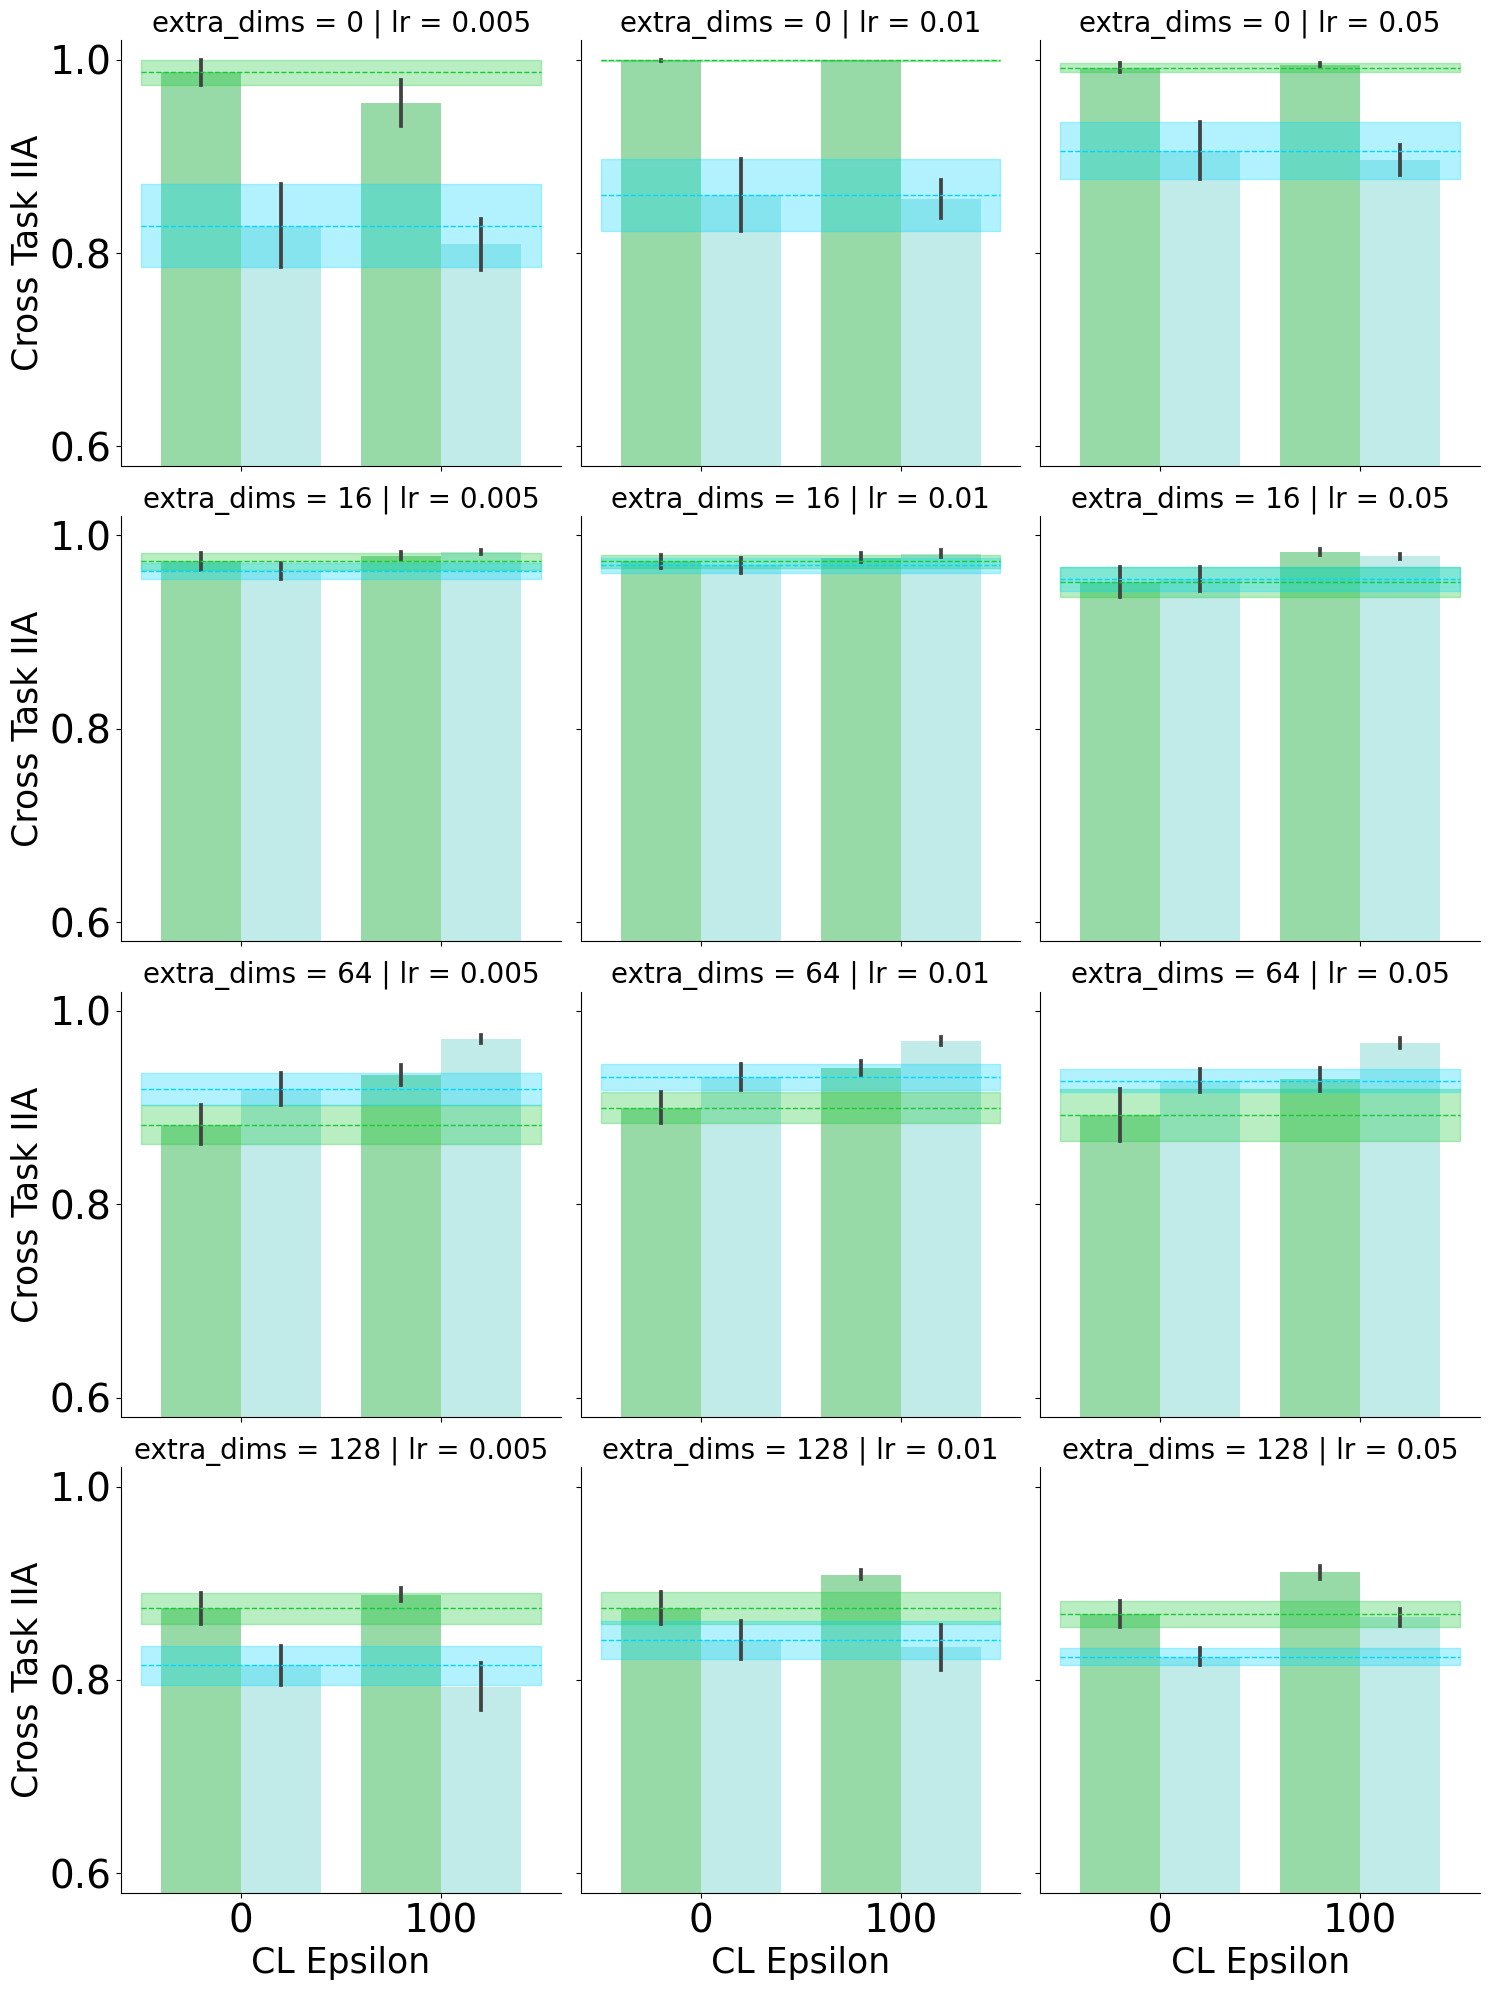

In [68]:
cl_only = True
incl_filters = {
    #"mtx_type": ["orthog"],
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    #"extra_dims": [64], # 16,],
    "mask_dims": [1,],
    #"lr": [ 0.005 ],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    "task_division": ["inner_square"],
}
excl_filters = {
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

rot = 35
x = "cl_eps"
y = "cross_actn_acc"
#hue = "task_spacing"
hue = "loss_type"
col = "lr"
row = "extra_dims"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
p = {
    "Dense": sns.color_palette("pastel")[color_order[0]],
    "Sparse": sns.color_palette("pastel")[color_order[1]],
}
pp = {
    "Dense": sns.color_palette("bright")[color_order[0]],
    "Sparse": sns.color_palette("bright")[color_order[1]],
}
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 20
legendsize = 20
linewidth = 4

ylabel = "Cross Task IIA" if "cross" in y else "Trained Task IIA" 
ylim = [0.58,1.02]
yticks = [0.6, 0.8, 1.0]
if "acc" not in y:
    if "row" in y:
        ylabel = ylabel.replace("Task IIA", "Row EMD")
        yticks = [0,0.025,0.05, 0.075, 0.1, 0.125, 0.15]
        ylim = [0,0.155]
    else:
        ylabel = ylabel.replace("Task IIA", "EMD")
        yticks = None
        ylim = None
print(y)
iia_threshold = 0


plot_df = full_df.loc[full_df["mtx_type"]==mtx_type].copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)&(plot_df["actn_acc"]>iia_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()
#combo_df = plot_df.loc[plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]].copy()
#combo_df["cl_eps"] = 0
#combo_df["incl_cl_loss"] = True
#cl_df = combo_df.copy()
#cl_df["incl_actn_loss"] = False
#plot_df = pd.concat([ plot_df, combo_df, cl_df, ])

actn_bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
bloss_acc = dict(plot_df.loc[actn_bools].groupby(hue)[y].mean())
bloss_err = dict(plot_df.loc[actn_bools].groupby(hue)[y].sem())
print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)

#fig,axes = plt.subplots(1,2, figsize=(10,5))
if cl_only:
    temp_df = plot_df.loc[actn_bools|(~plot_df["incl_actn_loss"])].sort_values(by=["spacing_order",x], ascending=[True,False])
else:
    temp_df = plot_df.loc[plot_df["incl_actn_loss"]].sort_values(by=["spacing_order",x], ascending=[True,False])
temp_df["emd"] = temp_df["emd"]/(temp_df["extra_dims"]+1)
temp_df["cross_emd"] = temp_df["cross_emd"]/(temp_df["extra_dims"]+1)
g = sns.catplot(
    x=x, y=y,
    hue=hue,
    col=col,
    row=row,
    data=temp_df,
    ax=ax,
    palette=p,
    kind="bar",
    errorbar="se",
    legend=False,
)
n_cols = len(set(temp_df[col]))
for i,(_, ax) in enumerate(g.axes_dict.items()):
    row,col = i//n_cols, i%n_cols
    plt.sca(ax)
    title = ax.get_title() 
    r,c = title.split(" | ")
    rk,rv = r.strip().split(" = ")
    ck,cv = c.strip().split(" = ")
    try: rv = float(rv)
    except: pass
    try: cv = float(cv)
    except: pass

    # Baseline
    err_alpha = 0.3
    linewidth = 1
    actn_bools = temp_df["incl_actn_loss"]&~temp_df["incl_cl_loss"]
    rcbools = (temp_df[rk]==rv)&(temp_df[ck]==cv)
    bloss_acc = dict(temp_df.loc[actn_bools&rcbools].groupby(hue)[y].mean())
    bloss_err = dict(temp_df.loc[actn_bools&rcbools].groupby(hue)[y].sem())
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    for i,k in enumerate(bloss_acc):
        acc = bloss_acc[k]
        err = bloss_err[k]
        color = pp[k]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
    
    #plt.title("DAS + CL Loss", fontsize=titlesize)
    if ylim is not None:
        plt.ylim(ylim)
    #xlabel = " ".join([lab.capitalize() for lab in x.split("_")])
    #plt.xlabel(xlabel, fontsize=labelsize)
    plt.xlabel("CL Epsilon", fontsize=labelsize)
    plt.ylabel(ylabel, fontsize=labelsize)
    #plt.xticks(xticks, rotation=rot, fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    if yticks is None:
        plt.yticks(fontsize=ticksize)
    else:
        plt.yticks(yticks, fontsize=ticksize)
    plt.title(
        ax.get_title(),
        fontsize=titlesize
    )
    if i==9:
        plt.legend(
            title=leg_title,
            fontsize=legendsize,
            title_fontsize=legendsize
        )
    else:
        plt.legend(
            loc="lower left",
            title=leg_title,
            fontsize=legendsize,
            title_fontsize=legendsize
        ).set_visible(False)

## Baseline
#xs = list(range(len(set(plot_df[x]))))
#xs = [np.min(xs)-1] + xs + [np.max(xs)]
#xs = np.asarray(xs)
#for i,k in enumerate(bloss_acc):
#    acc = bloss_acc[k]
#    err = bloss_err[k]
#    color = p[i]
#    ys = np.asarray([acc for _ in xs])
#    plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
#    #plt.fill_between(xs, ys-err, ys+err, alpha=0.2, color=color, )

plt.tight_layout()
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.png", dpi=600, bbox_inches="tight")
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.pdf", dpi=600, bbox_inches="tight")
plt.show()

cross_actn_acc
Behavior Only Accuracy {'Dense': 0.9306666702032089, 'Sparse': 0.8950833340485891} +/- {'Dense': 0.007620701811679652, 'Sparse': 0.009240769770550968}


/home/grantsrb/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


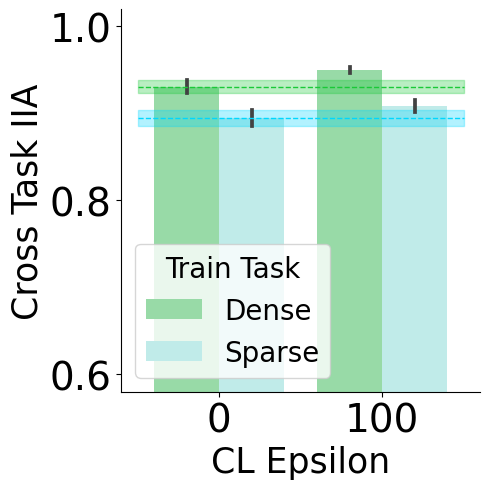

In [71]:
cl_only = True
incl_filters = {
    #"mtx_type": ["orthog"],
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    #"extra_dims": [64], # 16,],
    "mask_dims": [1,],
    #"lr": [ 0.05 ],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    "task_division": ["inner_square"],
}
excl_filters = {
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

rot = 35
x = "cl_eps"
y = "cross_actn_acc"
hue = "task_spacing"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
p = {
    "Dense": sns.color_palette("pastel")[color_order[0]],
    "Sparse": sns.color_palette("pastel")[color_order[1]],
}
pp = {
    "Dense": sns.color_palette("bright")[color_order[0]],
    "Sparse": sns.color_palette("bright")[color_order[1]],
}
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 20
legendsize = 20
linewidth = 4

ylabel = "Cross Task IIA" if "cross" in y else "Trained Task IIA" 
ylim = [0.58,1.02]
yticks = [0.6, 0.8, 1.0]
if "acc" not in y:
    if "row" in y:
        ylabel = ylabel.replace("Task IIA", "Row EMD")
        yticks = [0,0.025,0.05, 0.075, 0.1, 0.125, 0.15]
        ylim = [0,0.155]
    else:
        ylabel = ylabel.replace("Task IIA", "EMD")
        yticks = None
        ylim = None
print(y)
iia_threshold = 0


plot_df = full_df.loc[full_df["mtx_type"]==mtx_type].copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)&(plot_df["actn_acc"]>iia_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()
#combo_df = plot_df.loc[plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]].copy()
#combo_df["cl_eps"] = 0
#combo_df["incl_cl_loss"] = True
#cl_df = combo_df.copy()
#cl_df["incl_actn_loss"] = False
#plot_df = pd.concat([ plot_df, combo_df, cl_df, ])

actn_bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
bloss_acc = dict(plot_df.loc[actn_bools].groupby(hue)[y].mean())
bloss_err = dict(plot_df.loc[actn_bools].groupby(hue)[y].sem())
print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)

#fig,axes = plt.subplots(1,2, figsize=(10,5))
if cl_only:
    temp_df = plot_df.loc[actn_bools|(~plot_df["incl_actn_loss"])].sort_values(by=["spacing_order",x], ascending=[True,False])
else:
    temp_df = plot_df.loc[plot_df["incl_actn_loss"]].sort_values(by=["spacing_order",x], ascending=[True,False])
temp_df["emd"] = temp_df["emd"]/(temp_df["extra_dims"]+1)
temp_df["cross_emd"] = temp_df["cross_emd"]/(temp_df["extra_dims"]+1)
g = sns.catplot(
    x=x, y=y,
    hue=hue,
    data=temp_df,
    ax=ax,
    palette=p,
    kind="bar",
    legend=False,
    errorbar="se",
)
ax = plt.gca()
title = ax.get_title() 

# Baseline
err_alpha = 0.3
linewidth = 1
xs = list(range(len(set(temp_df[x]))))
xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
xs = np.asarray(xs)
for i,k in enumerate(bloss_acc):
    acc = bloss_acc[k]
    err = bloss_err[k]
    color = pp[k]
    ys = np.asarray([acc for _ in xs])
    plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
    plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )

#plt.title("DAS + CL Loss", fontsize=titlesize)
if ylim is not None:
    plt.ylim(ylim)
#xlabel = " ".join([lab.capitalize() for lab in x.split("_")])
#plt.xlabel(xlabel, fontsize=labelsize)
plt.xlabel("CL Epsilon", fontsize=labelsize)
plt.ylabel(ylabel, fontsize=labelsize)
#plt.xticks(xticks, rotation=rot, fontsize=ticksize)
plt.xticks(fontsize=ticksize)
if yticks is None:
    plt.yticks(fontsize=ticksize)
else:
    plt.yticks(yticks, fontsize=ticksize)
plt.title(
    ax.get_title(),
    fontsize=titlesize
)
plt.legend(
    title=leg_title,
    fontsize=legendsize,
    title_fontsize=legendsize
)

## Baseline
#xs = list(range(len(set(plot_df[x]))))
#xs = [np.min(xs)-1] + xs + [np.max(xs)]
#xs = np.asarray(xs)
#for i,k in enumerate(bloss_acc):
#    acc = bloss_acc[k]
#    err = bloss_err[k]
#    color = p[i]
#    ys = np.asarray([acc for _ in xs])
#    plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
#    #plt.fill_between(xs, ys-err, ys+err, alpha=0.2, color=color, )

plt.tight_layout()
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.png", dpi=600, bbox_inches="tight")
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
fig = plt.figure()
temp_df = plot_df.loc[plot_df["incl_cl_loss"]&plot_df["incl_actn_loss"]].sort_values(by=x, ascending=False)
ax = plt.gca()
sns.barplot(x=x, y=y, hue=hue, data=temp_df, ax=ax, palette=p)
plt.title("DAS + CL Loss", fontsize=titlesize)
plt.ylim(ylim)
#xlabel = " ".join([lab.capitalize() for lab in x.split("_")])
#plt.xlabel(xlabel, fontsize=labelsize)
plt.xlabel("CL Epsilon", fontsize=labelsize)
plt.ylabel("Cross Task IIA", fontsize=labelsize)
#plt.xticks(xticks, rotation=rot, fontsize=ticksize)
plt.xticks(fontsize=ticksize)
plt.yticks(yticks, fontsize=ticksize)
plt.legend(
    loc="lower left",
    bbox_to_anchor=(1,0),
    title=leg_title,
    fontsize=legendsize,
    title_fontsize=legendsize
)
plt.savefig("figs/ood_legend.png", dpi=600,bbox_inches="tight")
plt.show()
